# Traffic Accident Severity Prediction 

# Table of Content  
[Section A: Introduction](#1)  
> [Background](#1.1)  
  [Important Problem](#1.2)  
  [The current solutions](#1.3)  
  [This report solution](#1.4)  

[Section B: Data Exploration](#2)  
> [Basic Collision Analysis](#2.1)  
  [Visualization of various features with the severity of accidents](#2.2)  
  [Visualization of collision occurrence time](#2.3)  

[Section C: Data Preprocessing](#3)  
> [Unreasonable feature processing](#3.1)  
  [Dealing with Missing and Unknown values](#3.2)  
  [Other Value Processing](#3.3)  
  [Data Munging](#3.4)
  [Final feature selection](#3.5)  
  
[Section D: Algorithms implementation](#4)  
> [MultinomialNB](#4.1)  
  [Random Forest](#4.2)  
  [LinearSVC](#4.3)  
  [XGBoost](#4.4)
  
[Section E: Results presented and analysis](#5)  
> [Business understanding](#5.1)  
 
 More detailed process of descriptive analysis will be presented in the report

# Section A: Introduction <a class="anchor" id="1"></a>

## Background <a class="anchor" id="1.1"></a>

In the United States, the number of road-traffic related injuries decreased by roughly 17 percent between 2019 and 2020, whereas fatalities increased by almost 8 percent. Between 2010 and 2020, road traffic injuries in the United States grew by nearly 34,000 incidents to some 2.28 million road traffic related injuries in 2020. This is an important issue for communities around the world, and Seattle is no exception.

## Important Problem <a class="anchor" id="1.2"></a>

SDOT has provided a dataset with detailed information that may have contributed to the collision. The objective of this report is to predict the severity of traffic accidents in Seattle based on this data, which will help to reduce the number of accidents and injuries.


Therefore, the main objectives of this analysis are:
1. Performing exploratory and visual analysis on the data to gain useful insights.
2. Developing an advanced algorithm for predicting the severity of accidents.

## The current solutions <a class="anchor" id="1.3"></a>

Traditionally, statistical analysis and machine learning methods have been used to predict the severity of traffic accidents. The analysis methods such as logistic regression, random forest, k-nearest neighbors, support vector machine, and neural network have been employed. However, these methods have their benefits and drawbacks. For instance, logistic regression is simple and interpretable, but it may not perform well with nonlinear data. Conversely, neural networks can handle nonlinear data, but they may overfit the training data and require significant computational resources.

## This report solution <a class="anchor" id="1.4"></a>

To address the limitations of existing solutions, this report will be using an advanced machine learning method called Gradient Boosting. Gradient Boosting is a tree-based ensemble method, it can handle nonlinear data and has a relatively low risk of overfitting. Additionally, Gradient Boosting has been shown to perform well in previous studies for similar classification problems. Moreover, this report will compare the proposed algorithm with traditional machine learning methods to investigate the performance improvement of the solution.

In [1]:
import pprint
import squarify
import graphviz
%matplotlib inline
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.tree import export_graphviz

import warnings
warnings.filterwarnings("ignore")

import missingno as msno
from sklearn import tree
from sklearn import metrics
from pandas import DataFrame
from sklearn import preprocessing
from category_encoders.one_hot import OneHotEncoder


from skopt import BayesSearchCV
from xgboost import plot_importance
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import ConfusionMatrixDisplay ,auc ,roc_curve
from sklearn.metrics import accuracy_score , recall_score, precision_score, f1_score

import xgboost as xgb
from sklearn.svm import SVC
from sklearn import neighbors
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


# Section B: Data Exploration <a class="anchor" id="2"></a>

In [2]:
filename = "Collisions.csv"
data = pd.read_csv(filename)
#data.head()

In [3]:
data.shape

(240117, 38)

In [4]:
data.columns

Index(['OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS', 'ADDRTYPE',
       'INTKEY', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'SEVERITYCODE',
       'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT',
       'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES',
       'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

In [5]:
data.SEVERITYCODE.value_counts(dropna=False).to_frame()

,SEVERITYCODE
1,148392
2,63608
0,24079
2b,3608
3,429
NaN,1


In [6]:
data.SEVERITYDESC.value_counts(dropna=False).to_frame()

,SEVERITYDESC
Property Damage Only Collision,148392
Injury Collision,63608
Unknown,24080
Serious Injury Collision,3608
Fatality Collision,429


In [7]:
data['SEVERITYCODE'].replace('0', np.nan, inplace=True)
data.dropna(subset=['SEVERITYCODE'], inplace=True)


In [8]:
data.SEVERITYCODE.value_counts(dropna=False).to_frame()

,SEVERITYCODE
1,148392
2,63608
2b,3608
3,429


In [9]:
# Get the time range of the dataset
start_date = pd.to_datetime(data['INCDATE'].min()).strftime('%B %d, %Y')
end_date = pd.to_datetime(data['INCDATE'].max()).strftime('%B %d, %Y')
print(f"The dataset covers a time range from {start_date} to {end_date}.")

The dataset covers a time range from January 01, 2004 to February 22, 2023.


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216037 entries, 0 to 240116
Data columns (total 38 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   OBJECTID         216037 non-null  int64  
 1   INCKEY           216037 non-null  int64  
 2   COLDETKEY        216037 non-null  int64  
 3   REPORTNO         216037 non-null  object 
 4   STATUS           216037 non-null  object 
 5   ADDRTYPE         214078 non-null  object 
 6   INTKEY           74451 non-null   float64
 7   LOCATION         213287 non-null  object 
 8   EXCEPTRSNCODE    104406 non-null  object 
 9   EXCEPTRSNDESC    5876 non-null    object 
 10  SEVERITYCODE     216037 non-null  object 
 11  SEVERITYDESC     216037 non-null  object 
 12  COLLISIONTYPE    207986 non-null  object 
 13  PERSONCOUNT      216037 non-null  int64  
 14  PEDCOUNT         216037 non-null  int64  
 15  PEDCYLCOUNT      216037 non-null  int64  
 16  VEHCOUNT         216037 non-null  int6

In [11]:
data.nunique()

OBJECTID           216037
INCKEY             216037
COLDETKEY          216037
REPORTNO           216034
STATUS                  2
ADDRTYPE                3
INTKEY               7911
LOCATION            24772
EXCEPTRSNCODE           2
EXCEPTRSNDESC           1
SEVERITYCODE            4
SEVERITYDESC            4
COLLISIONTYPE          10
PERSONCOUNT            49
PEDCOUNT                7
PEDCYLCOUNT             4
VEHCOUNT               16
INJURIES               16
SERIOUSINJURIES         7
FATALITIES              6
INCDATE              6989
INCDTTM            180424
JUNCTIONTYPE            7
SDOT_COLCODE           41
SDOT_COLDESC           41
INATTENTIONIND          1
UNDERINFL               4
WEATHER                12
ROADCOND                9
LIGHTCOND               9
PEDROWNOTGRNT           1
SDOTCOLNUM         116998
SPEEDING                1
ST_COLCODE             64
ST_COLDESC             63
SEGLANEKEY           2158
CROSSWALKKEY         2358
HITPARKEDCAR            2
dtype: int64

In [12]:
print(data.INTKEY.value_counts(dropna=False).to_frame())
print()
print(data.PERSONCOUNT.value_counts(dropna=False).to_frame())
print()
print(data.PEDCOUNT.value_counts(dropna=False).to_frame())
print()
print(data.PEDCYLCOUNT.value_counts(dropna=False).to_frame())
print()
print(data.VEHCOUNT.value_counts(dropna=False).to_frame())
print()
print(data.INJURIES.value_counts(dropna=False).to_frame())
print()
print(data.SERIOUSINJURIES.value_counts(dropna=False).to_frame())
print()
print(data.FATALITIES.value_counts(dropna=False).to_frame())
print()
print(data.SDOTCOLNUM.value_counts(dropna=False).to_frame())
print()
print(data.SEGLANEKEY.value_counts(dropna=False).to_frame())
print()
print(data.CROSSWALKKEY.value_counts(dropna=False).to_frame())

         INTKEY
NaN      141586
29973.0     284
29933.0     170
29913.0     147
30509.0     143
...         ...
26375.0       1
26624.0       1
32846.0       1
32232.0       1
35296.0       1

[7912 rows x 1 columns]

    PERSONCOUNT
2        127945
3         39795
4         16202
1         15509
5          7301
0          3804
6          2996
7          1261
8           579
9           242
10          141
11           61
12           35
14           24
13           23
17           12
15           11
16            8
20            6
44            6
19            6
25            6
18            6
26            5
22            5
29            4
31            3
28            3
37            3
23            3
32            3
34            3
24            3
27            3
47            3
30            2
21            2
36            2
81            1
35            1
48            1
43            1
41            1
57            1
53            1
39            1
54            1
93            

In [13]:
print(data.STATUS.value_counts(dropna=False).to_frame())
print()
print(data.ADDRTYPE.value_counts(dropna=False).to_frame())
print()
print(data.LOCATION.value_counts(dropna=False).to_frame())
print()
print(data.COLLISIONTYPE.value_counts(dropna=False).to_frame())
print()
print(data.JUNCTIONTYPE.value_counts(dropna=False).to_frame())
print()
print(data.INATTENTIONIND.value_counts(dropna=False).to_frame())
print()
print(data.UNDERINFL.value_counts(dropna=False).to_frame())
print()
print(data.WEATHER.value_counts(dropna=False).to_frame())
print()
print(data.ROADCOND.value_counts(dropna=False).to_frame())
print()
print(data.LIGHTCOND.value_counts(dropna=False).to_frame())
print()
print(data.PEDROWNOTGRNT.value_counts(dropna=False).to_frame())
print()
print(data.SPEEDING.value_counts(dropna=False).to_frame())
print()
print(data.SEGLANEKEY.value_counts(dropna=False).to_frame())
print()
print(data.CROSSWALKKEY.value_counts(dropna=False).to_frame())
print()
print(data.HITPARKEDCAR.value_counts(dropna=False).to_frame())        

           STATUS
Matched    208001
Unmatched    8036

              ADDRTYPE
Block           138836
Intersection     74451
NaN               1959
Alley              791

                                                    LOCATION
NaN                                                     2750
AURORA AVE N BETWEEN N 117TH PL AND N 125TH ST           289
N NORTHGATE WAY BETWEEN MERIDIAN AVE N AND CORL...       285
6TH AVE AND JAMES ST                                     284
AURORA AVE N BETWEEN N 130TH ST AND N 135TH ST           283
...                                                      ...
32ND AVE W AND W LYNN ST                                   1
W BARRETT ST BETWEEN PROSCH AVE W AND 14TH AVE W           1
NOB HILL AVE N BETWEEN DEAD END 4 AND NEWELL ST            1
W BOSTON ST BETWEEN 29TH AVE W AND 30TH AVE W              1
46TH AVE S AND S FLETCHER ST                               1

[24773 rows x 1 columns]

            COLLISIONTYPE
Parked Car          50952
Angles            

In [14]:
print(data.EXCEPTRSNCODE.value_counts(dropna=False).to_frame())
print(data.EXCEPTRSNDESC.value_counts(dropna=False).to_frame())
print()
print(data.INCDATE.value_counts(dropna=False).to_frame())
print(data.INCDTTM.value_counts(dropna=False).to_frame())
print()  
print(data.SDOT_COLCODE.value_counts(dropna=False).to_frame())
print(data.SDOT_COLDESC.value_counts(dropna=False).to_frame())
print()
print(data.ST_COLCODE.value_counts(dropna=False).to_frame())
print(data.ST_COLDESC.value_counts(dropna=False).to_frame())

     EXCEPTRSNCODE
NaN         111631
             98530
NEI           5876
                                                    EXCEPTRSNDESC
NaN                                                        210161
Not Enough Information, or Insufficient Locatio...           5876

                        INCDATE
2006/11/02 00:00:00+00      100
2008/10/03 00:00:00+00       93
2005/05/18 00:00:00+00       87
2006/01/13 00:00:00+00       85
2005/11/05 00:00:00+00       84
...                         ...
2023/02/22 00:00:00+00        1
2015/12/25 00:00:00+00        1
2023/02/09 00:00:00+00        1
2023/02/08 00:00:00+00        1
2023/02/06 00:00:00+00        1

[6989 rows x 1 columns]
                       INCDTTM
11/2/2006                  100
10/3/2008                   92
11/5/2005                   84
12/4/2004                   76
6/1/2006                    75
...                        ...
1/26/2010 12:50:00 PM        1
8/30/2010 9:30:00 PM         1
12/1/2010 12:42:00 PM        1
10/1/2

## Basic Collision Analysis <a class="anchor" id="2.1"></a>

Data Summary

#|Feature/Attribute| |Dtype| |index| | | |comments|
| :- | :-: |-| :-: |-| :-: |-|:-:|-| -: |
|0|   OBJECTID           | |int64  | |      240117||||unique identifier|
|1|   INCKEY             | |int64  | |      240117||||unique identifier|
|2|   COLDETKEY          | |int64  | |      240117||||unique identifier|
|3|   REPORTNO           | |object | |      240114||||unique identifier|
|4|   STATUS             | |object | |      2||||no explanation|
|5|   ADDRTYPE           | |object | |      3||||Block, Intersection, Alley, NaN
|
|6|   INTKEY             | |float64| |      8153||||Key that corresponds to the intersection associated with a collision |
|7|   LOCATION           | |object | |      25789||||Description of the general location of the collision |
|8|   EXCEPTRSNCODE      | |object | |      2||||no explanation|
|9|   EXCEPTRSNDESC      | |object | |      1||||no explanation|
|10|  SEVERITYCODE       | |object | |      5||||Severity of car accidents|
|11|  SEVERITYDESC       | |object | |      5||||A detailed description of the severity of the collision|
|12|  COLLISIONTYPE      | |object | |      10||||Parked Car, Angles, Rear Ended, Sideswipe, Left Turn, Pedestrian, Cycles, Right Turn, Head On, Other, NaN|
|13|  PERSONCOUNT        | |int64  | |      49||||The total number of people involved in the collision|
|14|  PEDCOUNT           | |int64  | |      7||||The number of pedestrians involved in the collision. This is entered by the state|
|15|  PEDCYLCOUNT        | |int64  | |      4||||The number of bicycles involved in the collision. This is entered by the state|
|16|  VEHCOUNT           | |int64  | |      16||||The number of vehicles involved in the collision. This is entered by the state|
|17|  INJURIES           | |int64  | |      16||||The number of total injuries in the collision. This is entered by the state|
|18|  SERIOUSINJURIES    | |int64  | |      7||||The number of serious injuries in the collision. This is entered by the state|
|19|  FATALITIES         | |int64  | |      6||||The number of fatalities in the collision. This is entered by the state|
|20|  INCDATE            | |object | |      183056||||Times|
|21|  INCDTTM            | |object | |      183056||||Times|
|22|  JUNCTIONTYPE       | |object | |      7||||Category of junction at which collision took place|
|23|  SDOT_COLCODE       | |float64| |      41|||||
|24|  SDOT_COLDESC       | |object | |      41|||||
|25|  INATTENTIONIND     | |object | |      1||||Y is True, NaN is False|
|26|  UNDERINFL          | |object | |      4||||Y and 1 is True, N and 0 is False, (Empty) is NaN|
|27|  WEATHER            | |object | |      12||||Clear, Raining, Overcast, Snowing, Fog/Smog/Smoke, Sleet/Hail/Freezing Rain, Blowing Sand/Dirt, Partly Cloudy, Severe Crosswind, Blowing Snow, Other, NaN, Unknown
|||
|28|  ROADCOND           | |object | |      9||||Dry, Wet, Ice, Snow/Slush, Standing Water, Sand/Mud/Dirt, Oil, Other, Unknown, NaN
|||
|29|  LIGHTCOND          | |object | |      9||||Daylight, Dark - Street Lights On, Dusk, Dawn, Dark - No Street Lights, Dark - Street Lights Off, Dark - Unknown Lighting, Other, Unknown, NaN|
|30|  PEDROWNOTGRNT      | |object | |      1 ||||Y is True, NaN is False|
|31|  SDOTCOLNUM         | |float64| |      127186|||||
|32|  SPEEDING           | |object | |      1||||Y is True, NaN is False|
|33|  ST_COLCODE         | |object | |      64|||||
|34|  ST_COLDESC         | |object | |      63|||||
|35|  SEGLANEKEY         | |int64  | |      2183||||A key for the lane segment in which the collision occurred|
|36|  CROSSWALKKEY       | |int64  | |      2372||||A key for the crosswalk at which the collision occurred|
|37|  HITPARKEDCAR       | |object | |      2||||Y is True, N is False|

In [18]:
#pip install squarify

In [19]:

def plot_treemap(data, column):
    # Calculate the counts and proportions of each category
    counts = data[column].value_counts()
    counts_pct = counts / counts.sum() * 100

    # Convert the categories, counts, and proportions to a DataFrame
    df = pd.DataFrame({column: counts.index, 'Counts': counts.values, 'Counts_pct': counts_pct.values})

    # Set up the color map
    color_map = {
        0: '#4B0082', 1: '#4169E1', 2: '#FF4500', 3: '#20B2AA' , 4: '#FFD700', 5: '#DC143C',6: '#8FBC8F',7: '#9932CC',
        8: '#00CED1',9: '#FF69B4',10: '#FFA500',11: '#8B008B',12: '#00FF00',13: '#FF6347',14: '#FFFF00'
    }

    colors = list(color_map.values())[:len(counts.index)]

    # Create labels for the treemap that show the category count and proportion
    label = [f"{i}\n({j} | {k:.2f}%)" for i, j, k in zip(df[column], df['Counts'], df['Counts_pct'])]

    # Plot the treemap
    plt.figure(figsize=(10, 5))
    plt.title(f'{column} Count')
    plt.axis('off')
    squarify.plot(sizes=df['Counts'], label=label, color=colors, alpha=.8, text_kwargs={'fontsize':6, 'color':'black'})
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    #plt.show()


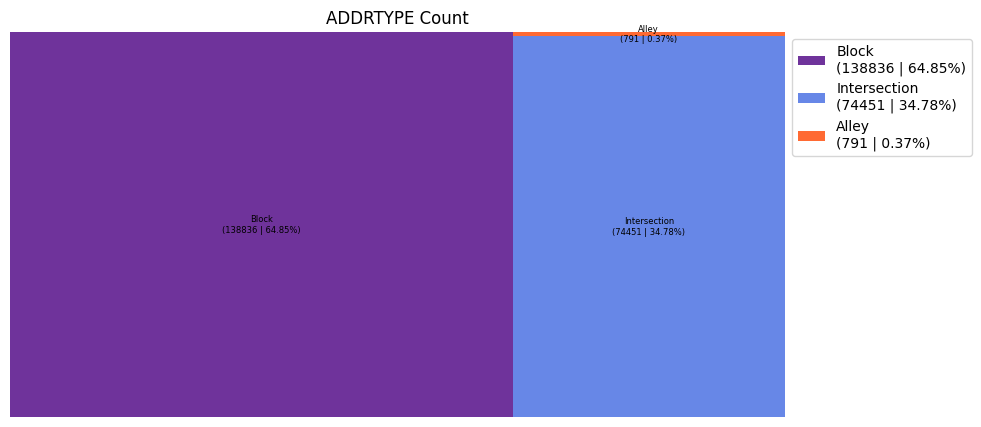

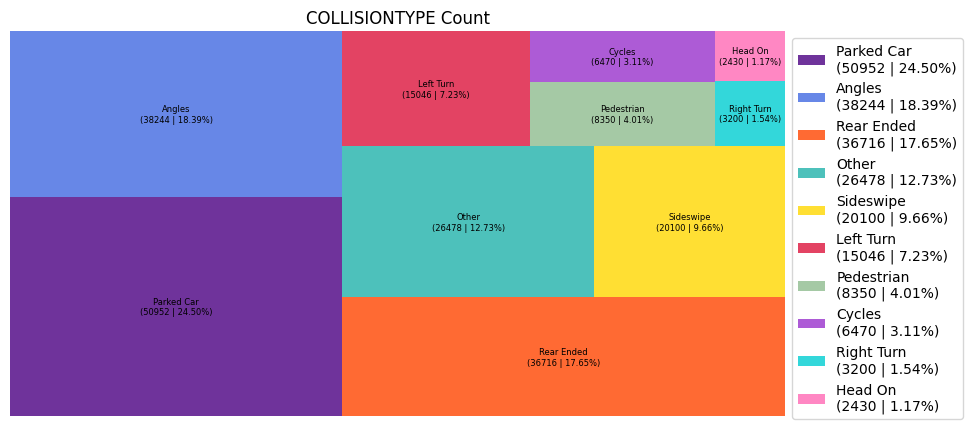

In [20]:
columns = ['ADDRTYPE', 'COLLISIONTYPE']

for column in columns:
    plot_treemap(data, column)
#    plt.savefig('{}_treemap.jpg'.format(column),dpi=1080)
    plt.show()

## Visualization of various features with the severity of accidents <a class="anchor" id="2.2"></a>

In [22]:
# Group data by 'JUNCTIONTYPE' column and count 'SEVERITYCODE' occurrences
data_grouped_j = data.groupby(['JUNCTIONTYPE'], dropna=False)['SEVERITYCODE'].value_counts(dropna=False).to_frame(name='value_counts')
data_grouped_j

value_counts
JUNCTIONTYPE                                      SEVERITYCODE              
At Intersection (but not related to intersection) 1                     1548
                                                  2                      657
                                                  2b                      25
                                                  3                        3
At Intersection (intersection related)            1                    40046
                                                  2                    30042
                                                  2b                    1778
                                                  3                      182
Driveway Junction                                 1                     7539
                                                  2                     3285
                                                  2b                     140
                                                  3                        8
Mid-Block (but intersection related)              1                    15846
                                                  2                     7488
                                                  2b                     191
                                                  3                       20
Mid-Block (not related to intersection)           1                    77200
                                                  2                    21655
                                                  2b                    1448
                                                  3                      215
Ramp Junction                                     1                      113
                                                  2                       55
                                                  2b                       5
Unknown                                           1                       11
                                                  2                        2
                                                  2b                       1
NaN                                               1                     6089
                                                  2                      424
                                                  2b                      20
                                                  3                        1

In [23]:
# Select the 'JUNCTIONTYPE' column from the 'data' DataFrame and assign it to 'data_junction_severity'
data_junction_severity = data['JUNCTIONTYPE']

# Replace any missing values (NaN) in 'data_junction_severity' with the string 'Unknown'
data_junction_severity = data_junction_severity.replace(np.nan,'Unknown')
data_junction_severity

0          At Intersection (intersection related)
1         Mid-Block (not related to intersection)
2                                         Unknown
3         Mid-Block (not related to intersection)
4         Mid-Block (not related to intersection)
                           ...                   
240112     At Intersection (intersection related)
240113     At Intersection (intersection related)
240114     At Intersection (intersection related)
240115     At Intersection (intersection related)
240116     At Intersection (intersection related)
Name: JUNCTIONTYPE, Length: 216037, dtype: object

In [24]:
# Combine the 'data_junction_severity' Series with a one-hot encoded representation of the 'SEVERITYCODE' column
data_junction_severity = pd.concat([data_junction_severity,pd.get_dummies(data['SEVERITYCODE'])], axis=1)

# Rename the columns of 'data_junction_severity' using a dictionary of new column names.
data_junction_severity.rename(columns={'1': '1    Property Damage','2': '2    Injury Collision','2b': '2b  Serious Injury Collision'
                                    ,'3': '3    Fatality Collision'},inplace=True)
data_junction_severity

,JUNCTIONTYPE,1 Property Damage,2 Injury Collision,2b Serious Injury Collision,3 Fatality Collision
0,At Intersection (intersection related),1,0,0,0
1,Mid-Block (not related to intersection),1,0,0,0
2,Unknown,1,0,0,0
3,Mid-Block (not related to intersection),1,0,0,0
4,Mid-Block (not related to intersection),0,1,0,0
...,...,...,...,...,...
240112,At Intersection (intersection related),0,1,0,0
240113,At Intersection (intersection related),0,1,0,0
240114,At Intersection (intersection related),1,0,0,0
240115,At Intersection (intersection related),1,0,0,0


In [143]:
# Group the 'data_junction_severity' Series by 'JUNCTIONTYPE' and sum the values for each group
# Sort the resulting grouped data in descending order based on the value of the '1    Property Damage' column
grouped_j_for_plot = data_junction_severity.groupby(['JUNCTIONTYPE'], dropna=False).sum().sort_values(by=['1    Property Damage'],ascending=[0])
grouped_j_for_plot

,1 Property Damage,2 Injury Collision,2b Serious Injury Collision,3 Fatality Collision
JUNCTIONTYPE,,,,
Mid-Block (not related to intersection),77200,21655,1448,215
At Intersection (intersection related),40046,30042,1778,182
Mid-Block (but intersection related),15846,7488,191,20
Driveway Junction,7539,3285,140,8
Unknown,6100,426,21,1
At Intersection (but not related to intersection),1548,657,25,3
Ramp Junction,113,55,5,0


In [144]:
# Define a function called 'autolabel' that takes an 'ax' (AxesSubplot) object as input.

def autolabel(ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
# Iterate through each rectangle (bar) in the plot
    for rect in ax.patches:
        # Get the width (height) of the bar
        width = rect.get_width()
        
        # Add a text annotation to the bar displaying its width as an integer value
        ax.annotate('{}'.format(int(width)), 
                    xy=(width, rect.get_y() + rect.get_height() / 2 * 2.6), # Position the annotation above the center of the bar
                    xytext=(0, 3),  # 3 points vertical offset for the text
                    fontsize=12,
                    textcoords="offset points", # The offset is specified in points
                    ha='left', va='bottom') # Horizontal and vertical alignment of the text
        
    # Return the modified 'ax' object
    return ax

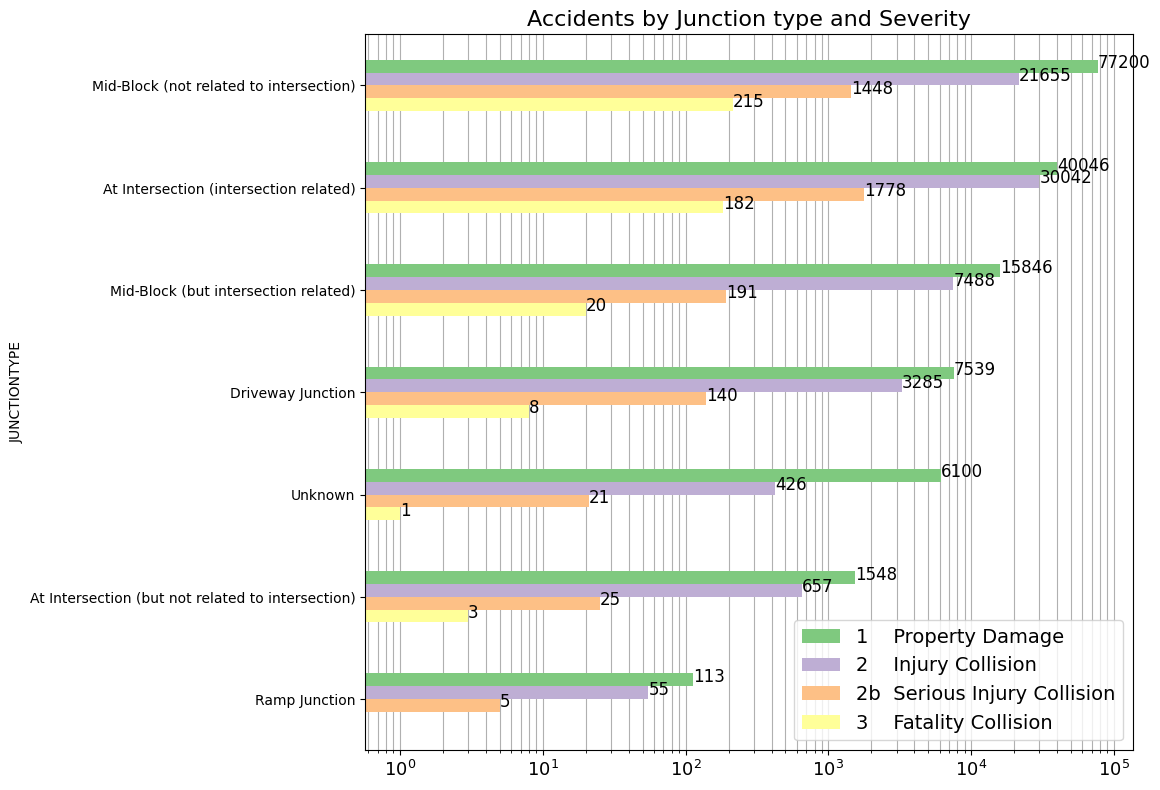

In [27]:
counts = data['JUNCTIONTYPE'].value_counts()

# Create a color map using the 'Accent' color map from Matplotlib and assign it to 'cmap'
cmap = cmap = plt.cm.Accent
colors = cmap(range(len(counts.index)))

fig, ax = plt.subplots()
# Create a horizontal bar plot of 'grouped_j_for_plot' using the 'plot' method of the 'ax' object, and customize the plot appearance
ax = grouped_j_for_plot.plot(kind="barh",figsize=(12.5,8), rot=0,
                          color=colors, 
                          fontsize=13, logx=True, zorder=2, ax=ax
                         )

ax.grid(which='both',axis='x', zorder=0)

ax.legend(fontsize=14, loc=4)
ax.set_title("Accidents by Junction type and Severity",fontsize=16)
plt.tight_layout()

ax = autolabel(ax)
ax.invert_yaxis()

ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
#plt.savefig('Accidents by Junction type and Severity.jpg',dpi=1080)
plt.show()

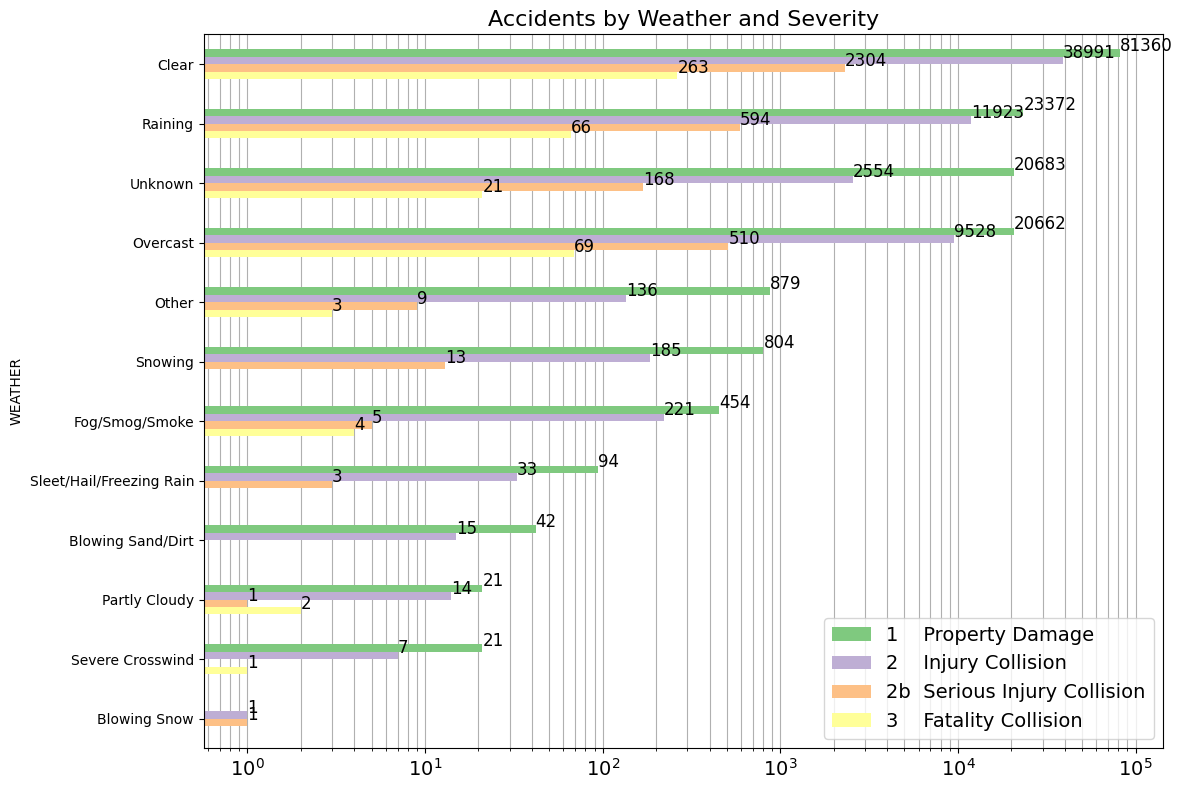

In [28]:
# Do the same for the weather
data_grouped_w = data.groupby(['WEATHER'], dropna=False)['SEVERITYCODE'].value_counts(dropna=False).to_frame(name='value_counts')


data_weather_severity = data['WEATHER']
data_weather_severity = data_weather_severity.replace(np.nan,'Unknown')

data_weather_severity = pd.concat([data_weather_severity,pd.get_dummies(data['SEVERITYCODE'])], axis=1)
data_weather_severity.rename(columns={'1': '1    Property Damage','2': '2    Injury Collision','2b': '2b  Serious Injury Collision'
                                    ,'3': '3    Fatality Collision'},inplace=True)


grouped_w_for_plot = data_weather_severity.groupby(['WEATHER'], dropna=False).sum().sort_values(by=['1    Property Damage'],ascending=[0])

counts = data['WEATHER'].value_counts()
cmap = cmap = plt.cm.Accent
colors = cmap(range(len(counts.index)))

fig, ax = plt.subplots()
ax = grouped_w_for_plot.plot(kind="barh",figsize=(12.5,8), rot=0,
                          color=colors, 
                          fontsize=14, logx=True, zorder=2, ax=ax
                         )

ax.grid(which='both',axis='x', zorder=0)

ax.legend(fontsize=14, loc=4)
ax.set_title("Accidents by Weather and Severity",fontsize=16)
plt.tight_layout()

ax = autolabel(ax)
ax.invert_yaxis()

ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
#plt.savefig('Accidents by Weather and Severity.jpg',dpi=1080)
plt.show()

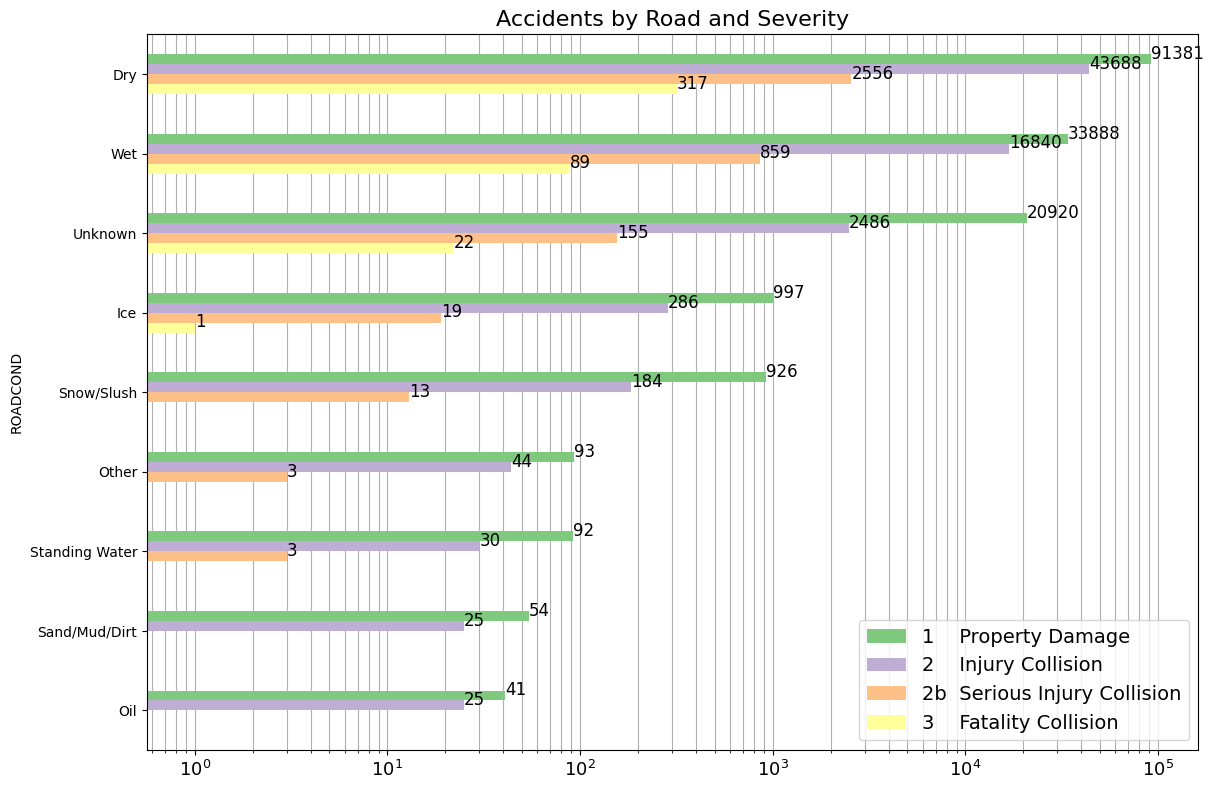

In [29]:
# Do the same for the road
data_grouped_r = data.groupby(['ROADCOND'], dropna=False)['SEVERITYCODE'].value_counts(dropna=False).to_frame(name='value_counts')

data_road_severity = data['ROADCOND']
data_road_severity = data_road_severity.replace(np.nan,'Unknown')

data_road_severity = pd.concat([data_road_severity,pd.get_dummies(data['SEVERITYCODE'])], axis=1)
data_road_severity.rename(columns={'1': '1    Property Damage','2': '2    Injury Collision','2b': '2b  Serious Injury Collision'
                                    ,'3': '3    Fatality Collision'},inplace=True)


grouped_r_for_plot = data_road_severity.groupby(['ROADCOND'], dropna=False).sum().sort_values(by=['1    Property Damage'],ascending=[0])

counts = data['ROADCOND'].value_counts()
cmap = cmap = plt.cm.Accent
colors = cmap(range(len(counts.index)))

fig, ax = plt.subplots()
ax = grouped_r_for_plot.plot(kind="barh",figsize=(12.5,8), rot=0,
                          color=colors, 
                          fontsize=13, logx=True, zorder=2, ax=ax
                         )

ax.grid(which='both',axis='x', zorder=0)

ax.legend(fontsize=14, loc=4)
ax.set_title("Accidents by Road and Severity",fontsize=16)
plt.tight_layout()

ax = autolabel(ax)
ax.invert_yaxis()

ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
#plt.savefig('Accidents by Road and Severity.jpg',dpi=1080)
plt.show()

In [30]:
data.LIGHTCOND.value_counts(dropna=False).to_frame()

,LIGHTCOND
Daylight,127286
Dark - Street Lights On,53886
Unknown,13747
NaN,8380
Dusk,6497
Dawn,2812
Dark - No Street Lights,1691
Dark - Street Lights Off,1300
Other,262
Dark - Unknown Lighting,176


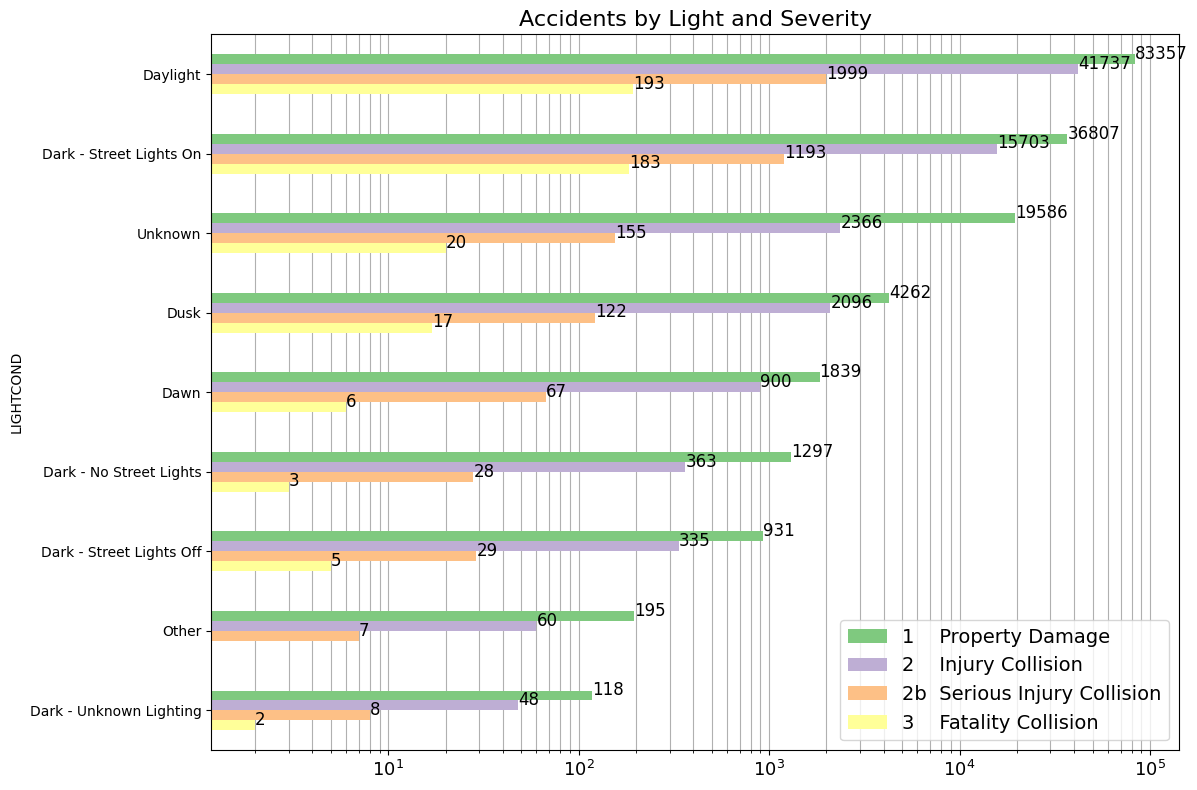

In [31]:
# Do the same for the light
data_grouped_l = data.groupby(['LIGHTCOND'], dropna=False)['SEVERITYCODE'].value_counts(dropna=False).to_frame(name='value_counts')


data_light_severity = data['LIGHTCOND']
data_light_severity = data_light_severity.replace(np.nan,'Unknown')

data_light_severity = pd.concat([data_light_severity,pd.get_dummies(data['SEVERITYCODE'])], axis=1)
data_light_severity.rename(columns={'1': '1    Property Damage','2': '2    Injury Collision','2b': '2b  Serious Injury Collision'
                                    ,'3': '3    Fatality Collision'},inplace=True)


grouped_l_for_plot = data_light_severity.groupby(['LIGHTCOND'], dropna=False).sum().sort_values(by=['1    Property Damage'],ascending=[0])

counts = data['LIGHTCOND'].value_counts()
cmap = cmap = plt.cm.Accent
colors = cmap(range(len(counts.index)))

fig, ax = plt.subplots()
ax = grouped_l_for_plot.plot(kind="barh",figsize=(12.5,8), rot=0,
                          color=colors, 
                          fontsize=13, logx=True, zorder=2, ax=ax
                         )

ax.grid(which='both',axis='x', zorder=0)

ax.legend(fontsize=14, loc=4)
ax.set_title("Accidents by Light and Severity",fontsize=16)
plt.tight_layout()

ax = autolabel(ax)
ax.invert_yaxis()

ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
#plt.savefig('Accidents by Light and Severity.jpg',dpi=1080)
plt.show()




## Visualization of collision occurrence time<a class="anchor" id="2.3"></a>

In [32]:
# Do the same for the time
data_date_severity = pd.to_datetime(data['INCDATE'], utc=True)
data_date_severity = pd.concat([data_date_severity,pd.get_dummies(data['SEVERITYCODE'])], axis=1)
data_date_severity.rename(columns={'1': '1    Property Damage','2': '2    Injury Collision','2b': '2b  Serious Injury Collision'
                                    ,'3': '3    Fatality Collision'},inplace=True)

# Extraction time and month
data_year_severity = data_date_severity.groupby(data_date_severity['INCDATE'].dt.strftime('%Y'), dropna=False).sum().astype('int64')
data_month_severity = data_date_severity.groupby(data_date_severity['INCDATE'].dt.strftime('%m'), dropna=False).sum().astype('int64')


In [33]:
data_year_severity

,1 Property Damage,2 Injury Collision,2b Serious Injury Collision,3 Fatality Collision
INCDATE,,,,
2004,8218,3647,222,30
2005,10665,4450,206,28
2006,10838,4350,293,34
2007,10439,4017,245,14
2008,9893,3767,193,20
2009,8356,3378,200,24
2010,7565,3245,179,18
2011,7820,3100,142,10
2012,7440,3466,176,20


In [34]:
data_month_severity

,1 Property Damage,2 Injury Collision,2b Serious Injury Collision,3 Fatality Collision
INCDATE,,,,
01,12652,5081,302,35
02,11050,4409,251,26
03,12191,5052,309,25
04,11993,5081,261,39
05,12511,5662,267,41
06,12774,5464,290,24
07,12403,5705,362,34
08,12336,5639,356,38
09,12139,5365,303,46


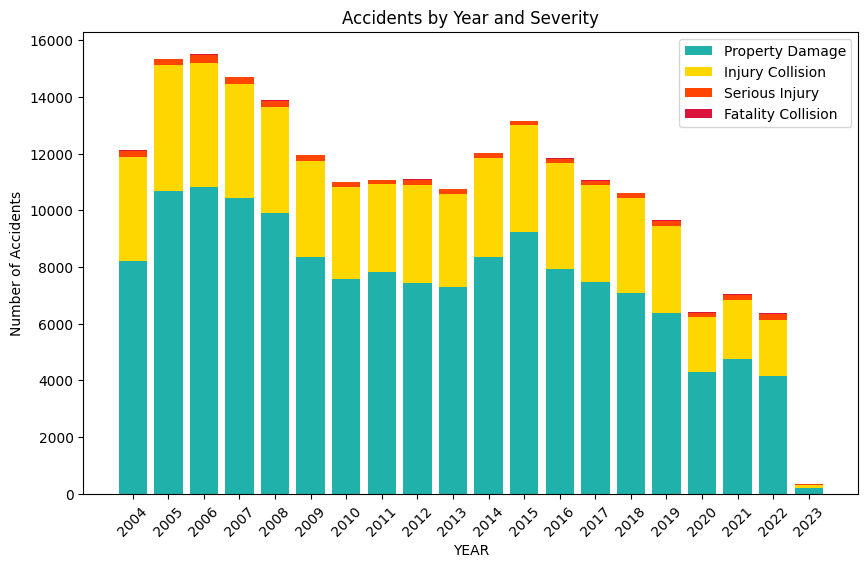

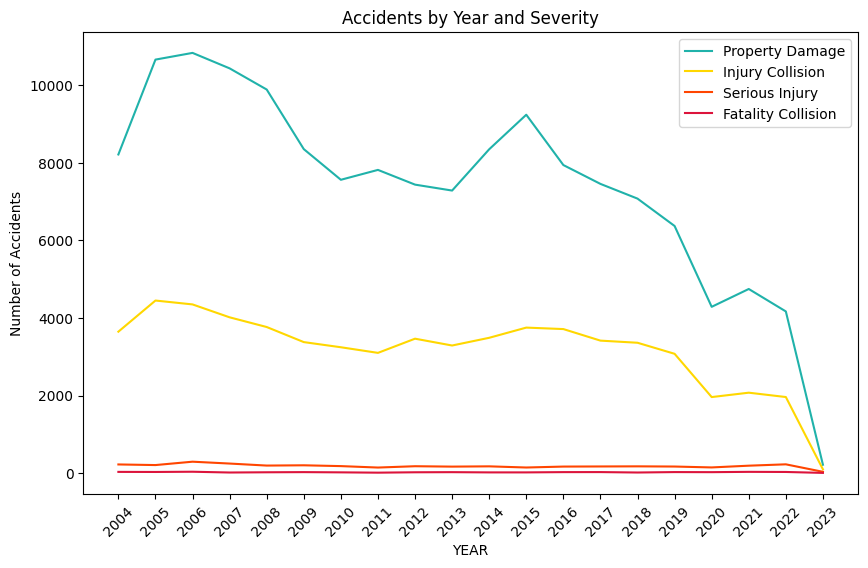

<Figure size 1000x1600 with 0 Axes>

In [35]:
data_ = data.copy()
years = data_year_severity.index
property_damage = data_year_severity['1    Property Damage']
injury_collision = data_year_severity['2    Injury Collision']
serious_injury = data_year_severity['2b  Serious Injury Collision']
fatality_collision = data_year_severity['3    Fatality Collision']


color_map = {
     0: '#20B2AA', 1: '#FFD700', 2: '#FF4500', 3: '#DC143C'
}

# Draw bar charts
fig, ax = plt.subplots(figsize=(10, 6))
bottom = 0
for i, (label, data_) in enumerate(zip(['Property Damage', 'Injury Collision', 'Serious Injury', 'Fatality Collision'], [property_damage, injury_collision, serious_injury, fatality_collision])):
    ax.bar(years, data_, bottom=bottom, label=label, color=color_map[i])
    bottom += data_
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('YEAR')
ax.set_ylabel('Number of Accidents')
ax.set_title('Accidents by Year and Severity')
ax.legend()

#plt.savefig('Accidents by Year and Severity - bar_chart.jpg',dpi=1080)

#Draw a line charts
fig, ax = plt.subplots(figsize=(10, 6))
for i, (label, data_) in enumerate(zip(['Property Damage', 'Injury Collision', 'Serious Injury', 'Fatality Collision'], [property_damage, injury_collision, serious_injury, fatality_collision])):
    ax.plot(years, data_, label=label, color=color_map[i])
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('YEAR')
ax.set_ylabel('Number of Accidents')
ax.set_title('Accidents by Year and Severity')
ax.legend()

#plt.savefig('Accidents by Year and Severity - line_chart.jpg',dpi=1080)

plt.figure(figsize=(10, 16))
plt.show()


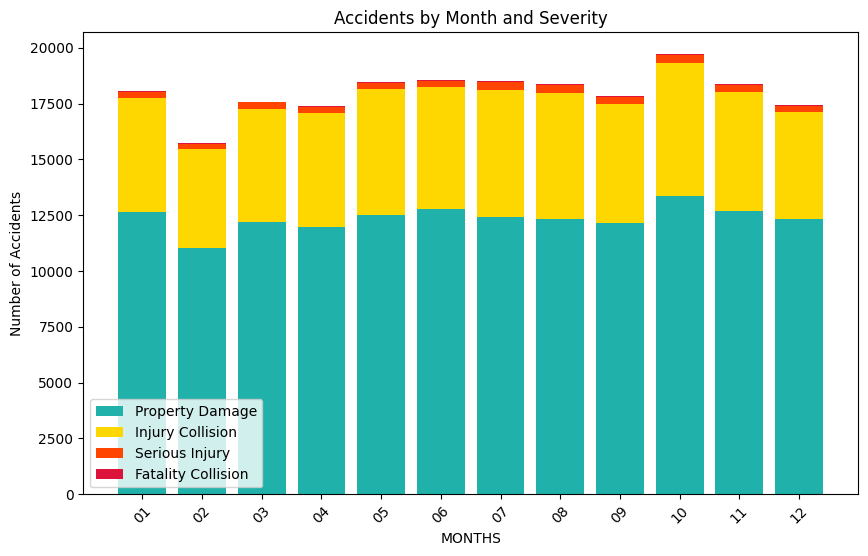

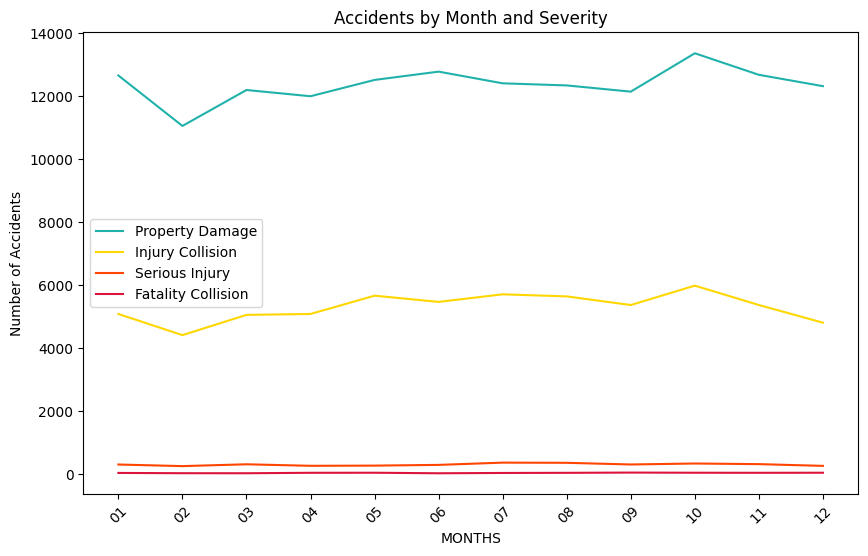

<Figure size 1000x1600 with 0 Axes>

In [36]:
months = data_month_severity.index
property_damage = data_month_severity['1    Property Damage']
injury_collision = data_month_severity['2    Injury Collision']
serious_injury = data_month_severity['2b  Serious Injury Collision']
fatality_collision = data_month_severity['3    Fatality Collision']


color_map = {
    0: '#20B2AA', 1: '#FFD700', 2: '#FF4500', 3: '#DC143C'
}


fig, ax = plt.subplots(figsize=(10, 6))
bottom = 0
for i, (label, data_) in enumerate(zip(['Property Damage', 'Injury Collision', 'Serious Injury', 'Fatality Collision'], [property_damage, injury_collision, serious_injury, fatality_collision])):
    ax.bar(months, data_, bottom=bottom, label=label, color=color_map[i])
    bottom += data_
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('MONTHS')
ax.set_ylabel('Number of Accidents')
ax.set_title('Accidents by Month and Severity')
ax.legend()

#plt.savefig('Accidents by Month and Severity - bar_chart.jpg',dpi=1080)

fig, ax = plt.subplots(figsize=(10, 6))
for i, (label, data_) in enumerate(zip(['Property Damage', 'Injury Collision', 'Serious Injury', 'Fatality Collision'], [property_damage, injury_collision, serious_injury, fatality_collision])):
    ax.plot(months, data_, label=label, color=color_map[i])
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('MONTHS')
ax.set_ylabel('Number of Accidents')
ax.set_title('Accidents by Month and Severity')
ax.legend()

#plt.savefig('Accidents by Month and Severity - line_chart.jpg',dpi=1080)

plt.figure(figsize=(10, 16))
plt.show()


# Section C: Data Preprocessing <a class="anchor" id="3"></a>


## Unreasonable feature processing <a class="anchor" id="3.1"></a>

In [37]:
data['INATTENTIONIND'].fillna('N', inplace=True)
data['UNDERINFL'] = data['UNDERINFL'].replace({1: 'Y', 0: 'N'})
data['UNDERINFL'].fillna('N', inplace=True)
data['PEDROWNOTGRNT'].fillna('N', inplace=True)
data['SPEEDING'].fillna('N', inplace=True)

In [38]:
data['LIGHTCOND'].replace({'Dark - No Street Lights': 'Dark - No Lighting',
                           'Dark - Street Lights Off': 'Dark - No Lighting'},
                          inplace=True)


In [39]:
data.columns

Index(['OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS', 'ADDRTYPE',
       'INTKEY', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'SEVERITYCODE',
       'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT',
       'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES',
       'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

## Dealing with Missing and Unknown values <a class="anchor" id="3.2"></a>

<Axes: >

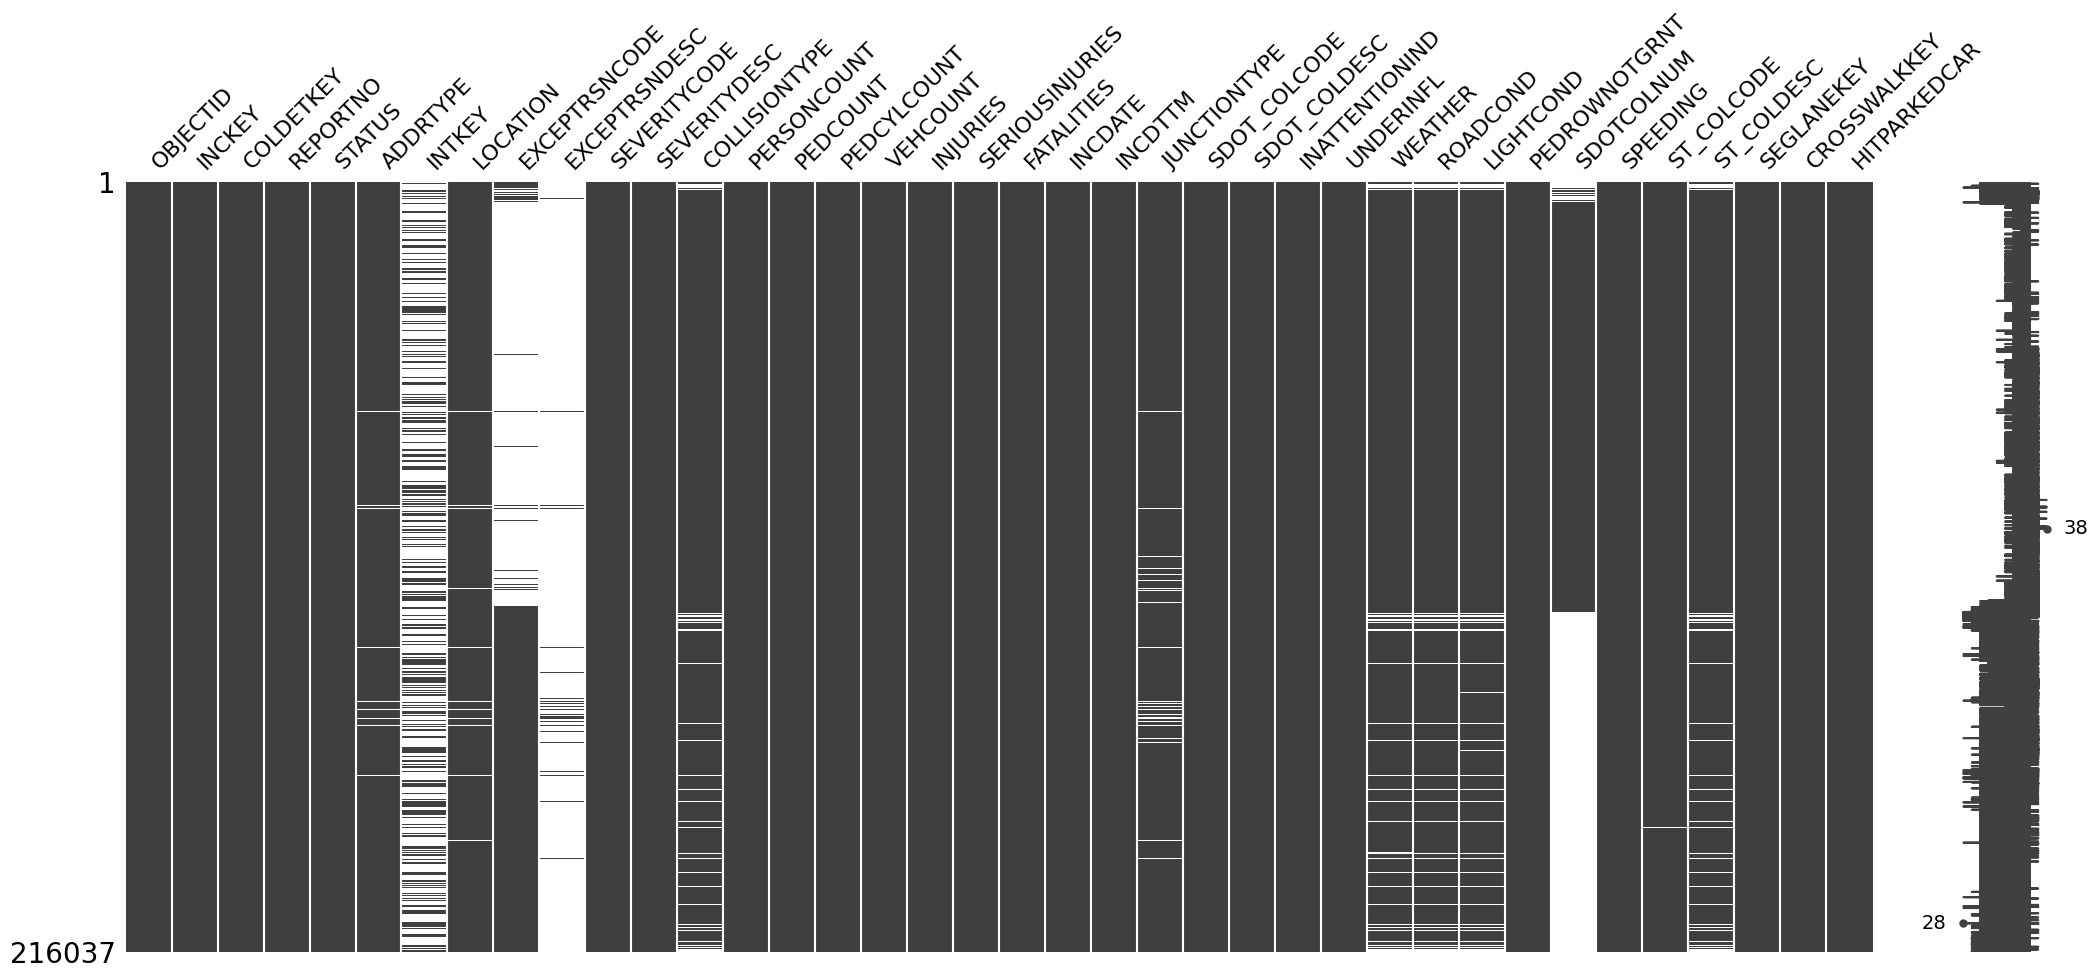

In [40]:
msno.matrix(data)

<Axes: >

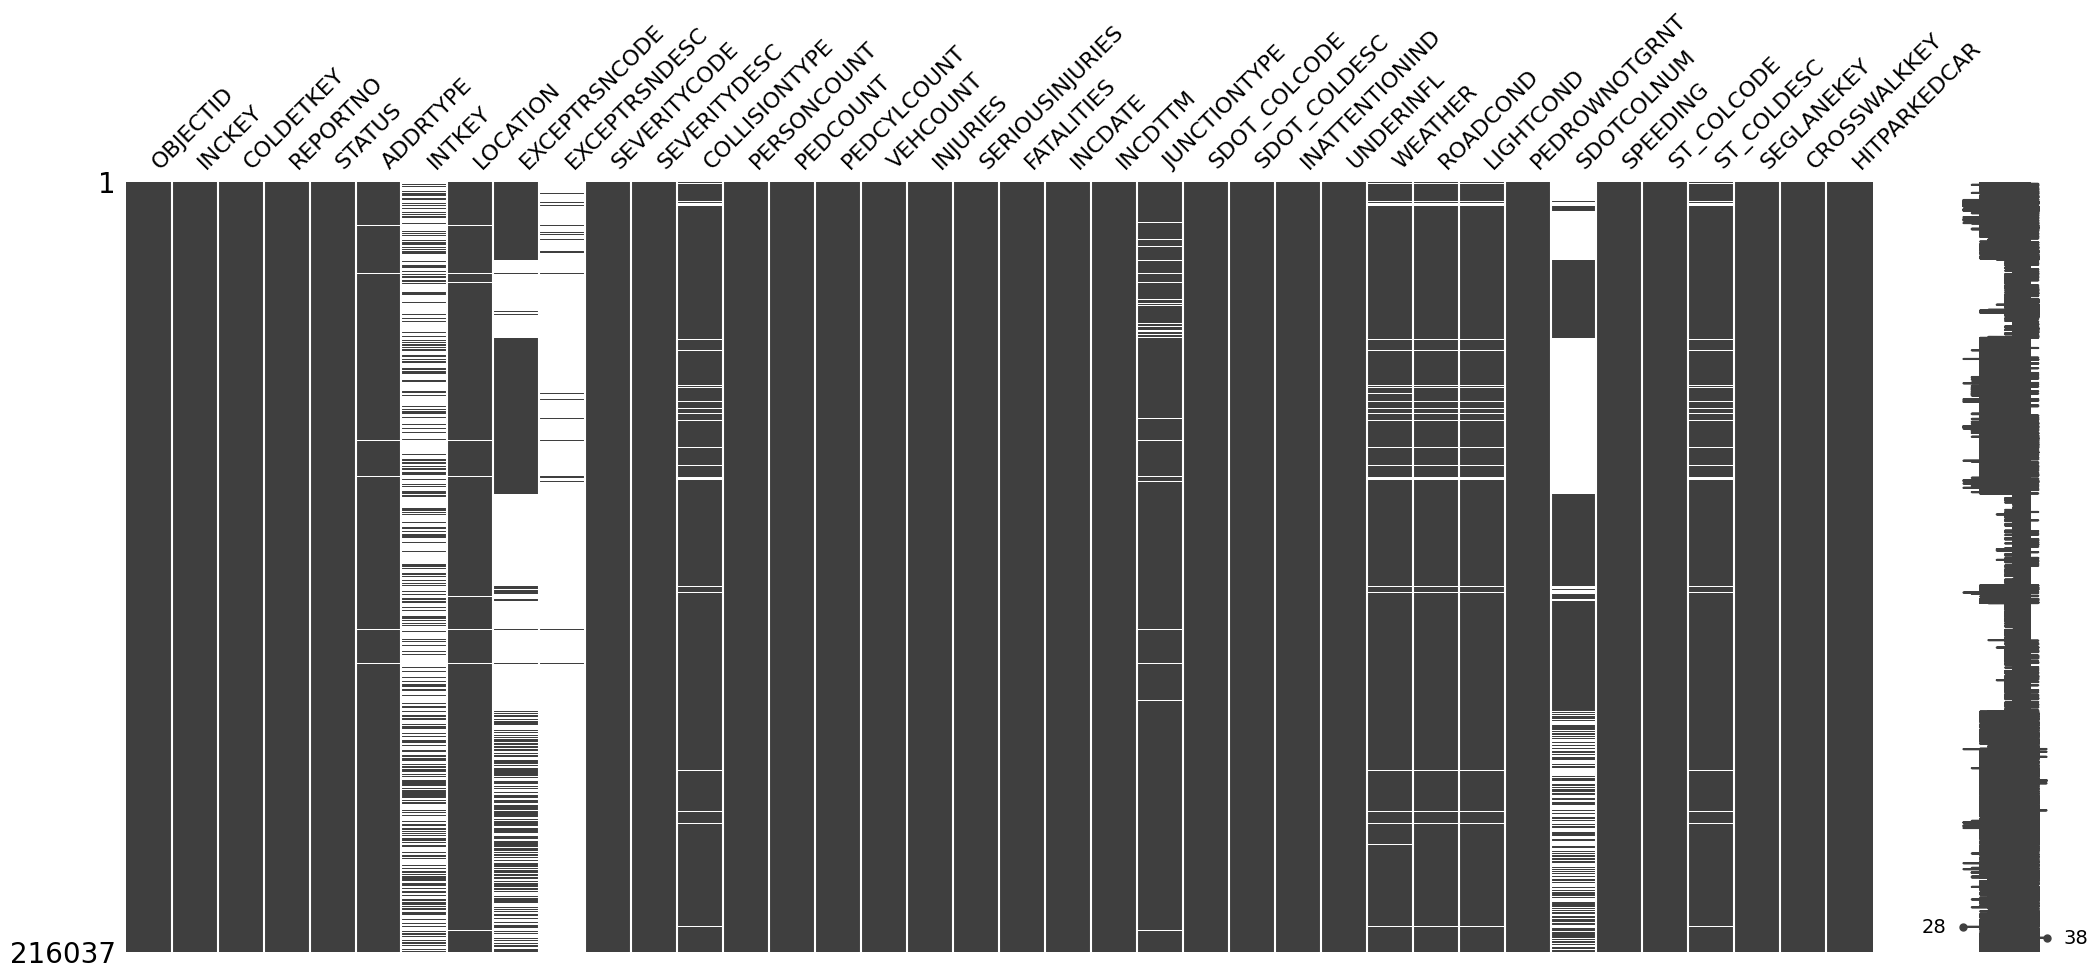

In [41]:
msno.matrix(data.sort_values('SEVERITYCODE'))
#plt.savefig('missing_data_matrix with sort SEVERITYCODE.jpg',dpi=1080)

For categorical features, SimpleImputer is generally used to fill in missing values. Using a determined value to fill in many Missing values may result in inaccurate inputs. Therefore, this report chooses a better method to fill in missing values, namely the Roulette Wheel Selection method. The Roulette Wheel Selection method is a probability-based selection algorithm, whose core idea is to calculate the corresponding selection probability based on the fitness value of everyone, and then use a roulette wheel to randomly select the next generation of individuals. This report fills in Missing values using a similar approach.

In [42]:
def roulette_wheel_replacena(df, column_name, show=False):
    # Calculate the original probability distribution of the column
    original_dist = df[column_name].value_counts(normalize=True, dropna=False)
    if show:
        print(f"{'-'*40}\nOriginal distribution:\n{original_dist}\n{'-'*40}")

    # Replace 'Unknown' values with NaN values
    df[column_name].replace(['Unknown'], np.nan, inplace=True)

    # Calculate the probability distribution of the column after removing NaN values
    non_null_dist = df[column_name].value_counts(normalize=True)
    
    # Sample random values from the non-null distribution to replace each NaN value
    nan_indices = df[column_name].isnull()
    nan_count = nan_indices.sum()
    weights = non_null_dist.values
    np.random.seed(42)
    new_values = np.random.choice(non_null_dist.index, size=nan_count, p=weights)
    df.loc[nan_indices, column_name] = new_values
        # Check if there are still any NaN values remaining in the column
    if df[column_name].isnull().sum() > 0:
        print("Error!")
    else:
        if show:
            replaced_dist = df[column_name].value_counts(normalize=True)
            print(f"Replacement distribution:\n{replaced_dist}\n{'-'*40}")
        print("Successful!")
        

The purpose of this code is to replace missing values in a column of a Pandas DataFrame with values sampled randomly based on the probability distribution of the non-missing values in the column. The function implements the roulette wheel selection algorithm to sample the replacement values. The function takes three arguments: the DataFrame containing the column to be imputed, the name of the column to be imputed, and a boolean flag indicating whether to print the original and replacement probability distributions. The function returns nothing but prints a success message if the imputation is successful, or an error message if there are still NaN values remaining in the column after the imputation.

In [43]:
roulette_wheel_replacena(data, 'ADDRTYPE', show=True)

----------------------------------------
Original distribution:
Block           0.642649
Intersection    0.344622
NaN             0.009068
Alley           0.003661
Name: ADDRTYPE, dtype: float64
----------------------------------------
Replacement distribution:
Block           0.648523
Intersection    0.347769
Alley           0.003708
Name: ADDRTYPE, dtype: float64
----------------------------------------
Successful!


In [44]:
roulette_wheel_replacena(data, 'COLLISIONTYPE', show=True)

----------------------------------------
Original distribution:
Parked Car    0.235848
Angles        0.177025
Rear Ended    0.169952
Other         0.122562
Sideswipe     0.093040
Left Turn     0.069645
Pedestrian    0.038651
NaN           0.037267
Cycles        0.029949
Right Turn    0.014812
Head On       0.011248
Name: COLLISIONTYPE, dtype: float64
----------------------------------------
Replacement distribution:
Parked Car    0.245213
Angles        0.183918
Rear Ended    0.176521
Other         0.127312
Sideswipe     0.096553
Left Turn     0.072247
Pedestrian    0.040086
Cycles        0.031161
Right Turn    0.015368
Head On       0.011623
Name: COLLISIONTYPE, dtype: float64
----------------------------------------
Successful!


In [45]:
roulette_wheel_replacena(data, 'WEATHER')

Successful!


In [46]:
roulette_wheel_replacena(data, 'ROADCOND')

Successful!


In [47]:
roulette_wheel_replacena(data, 'LIGHTCOND')

Successful!


In [48]:
roulette_wheel_replacena(data, 'JUNCTIONTYPE')

Successful!


## Other Value Processing <a class="anchor" id="3.3"></a> 

In [49]:
data['WEATHER'].replace('Other', np.nan, inplace=True)
data.dropna(subset=['WEATHER'], inplace=True)

In [50]:
data['ROADCOND'].replace('Other', np.nan, inplace=True)
data.dropna(subset=['ROADCOND'], inplace=True)

In [51]:
data['LIGHTCOND'].replace('Other', np.nan, inplace=True)
data.dropna(subset=['LIGHTCOND'], inplace=True)

In [52]:
data['COLLISIONTYPE'].replace('Other', np.nan, inplace=True)
data.dropna(subset=['COLLISIONTYPE'], inplace=True)

In [53]:
data.shape

(187157, 38)

In [54]:
data['INCDATE'] = pd.to_datetime(data['INCDATE'], utc=True)
data['MONTH'] = data['INCDATE'].dt.month

In [55]:
#Unique identifiers
data.drop('OBJECTID', axis=1, inplace=True)
data.drop('INCKEY', axis=1, inplace=True)
data.drop('COLDETKEY', axis=1, inplace=True)
data.drop('REPORTNO', axis=1, inplace=True)

#Unexplained variables
data.drop('STATUS', axis=1, inplace=True)
data.drop('EXCEPTRSNCODE', axis=1, inplace=True)
data.drop('EXCEPTRSNDESC', axis=1, inplace=True)

#Variables with too many values or not useful
data.drop('INTKEY', axis=1, inplace=True)
data.drop('LOCATION', axis=1, inplace=True)

#Descriptions
data.drop('SEVERITYDESC', axis=1, inplace=True)
data.drop('SDOT_COLDESC', axis=1, inplace=True)
data.drop('ST_COLDESC', axis=1, inplace=True)

#Date and time
data.drop('INCDTTM', axis=1, inplace=True)
data.drop('INCDATE', axis=1, inplace=True)

#Variables with no meaningful information
data.drop('SDOT_COLCODE', axis=1, inplace=True)
data.drop('SDOTCOLNUM', axis=1, inplace=True)
data.drop('ST_COLCODE', axis=1, inplace=True)

#One of the value has over 98% , which is not helpful for data exploration
data.drop('SEGLANEKEY', axis=1, inplace=True)
data.drop('CROSSWALKKEY', axis=1, inplace=True)


In [56]:
data.shape

(187157, 20)

In [57]:
data.columns

Index(['ADDRTYPE', 'SEVERITYCODE', 'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT',
       'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES',
       'JUNCTIONTYPE', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND',
       'LIGHTCOND', 'PEDROWNOTGRNT', 'SPEEDING', 'HITPARKEDCAR', 'MONTH'],
      dtype='object')

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187157 entries, 0 to 240116
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ADDRTYPE         187157 non-null  object
 1   SEVERITYCODE     187157 non-null  object
 2   COLLISIONTYPE    187157 non-null  object
 3   PERSONCOUNT      187157 non-null  int64 
 4   PEDCOUNT         187157 non-null  int64 
 5   PEDCYLCOUNT      187157 non-null  int64 
 6   VEHCOUNT         187157 non-null  int64 
 7   INJURIES         187157 non-null  int64 
 8   SERIOUSINJURIES  187157 non-null  int64 
 9   FATALITIES       187157 non-null  int64 
 10  JUNCTIONTYPE     187157 non-null  object
 11  INATTENTIONIND   187157 non-null  object
 12  UNDERINFL        187157 non-null  object
 13  WEATHER          187157 non-null  object
 14  ROADCOND         187157 non-null  object
 15  LIGHTCOND        187157 non-null  object
 16  PEDROWNOTGRNT    187157 non-null  object
 17  SPEEDING  

## Data Munging <a class="anchor" id="3.4"></a> 

In [59]:
#The higher the severity, the larger the number.
data['SEVERITYCODE'].replace('1', '0', inplace=True)
data['SEVERITYCODE'].replace('2', '1', inplace=True)
data['SEVERITYCODE'].replace('2b', '2', inplace=True)
data['SEVERITYCODE'] =  data['SEVERITYCODE'].astype('int64')

In [60]:
data['INATTENTIONIND'].replace({'N':'0', 'Y':'1'}, inplace=True)
data['INATTENTIONIND'] =  data['INATTENTIONIND'].astype('int64')

data['UNDERINFL'].replace({'N':'0', 'Y':'1'}, inplace=True)
data['UNDERINFL'] =  data['UNDERINFL'].astype('int64')

data['PEDROWNOTGRNT'].replace({'N':'0', 'Y':'1'}, inplace=True)
data['PEDROWNOTGRNT'] =  data['PEDROWNOTGRNT'].astype('int64')

data['SPEEDING'].replace({'N':'0', 'Y':'1'}, inplace=True)
data['SPEEDING'] =  data['SPEEDING'].astype('int64')

data['HITPARKEDCAR'].replace({'N':'0', 'Y':'1'}, inplace=True)
data['HITPARKEDCAR'] =  data['HITPARKEDCAR'].astype('int64')

## Final feature selection <a class="anchor" id="3.5"></a> 

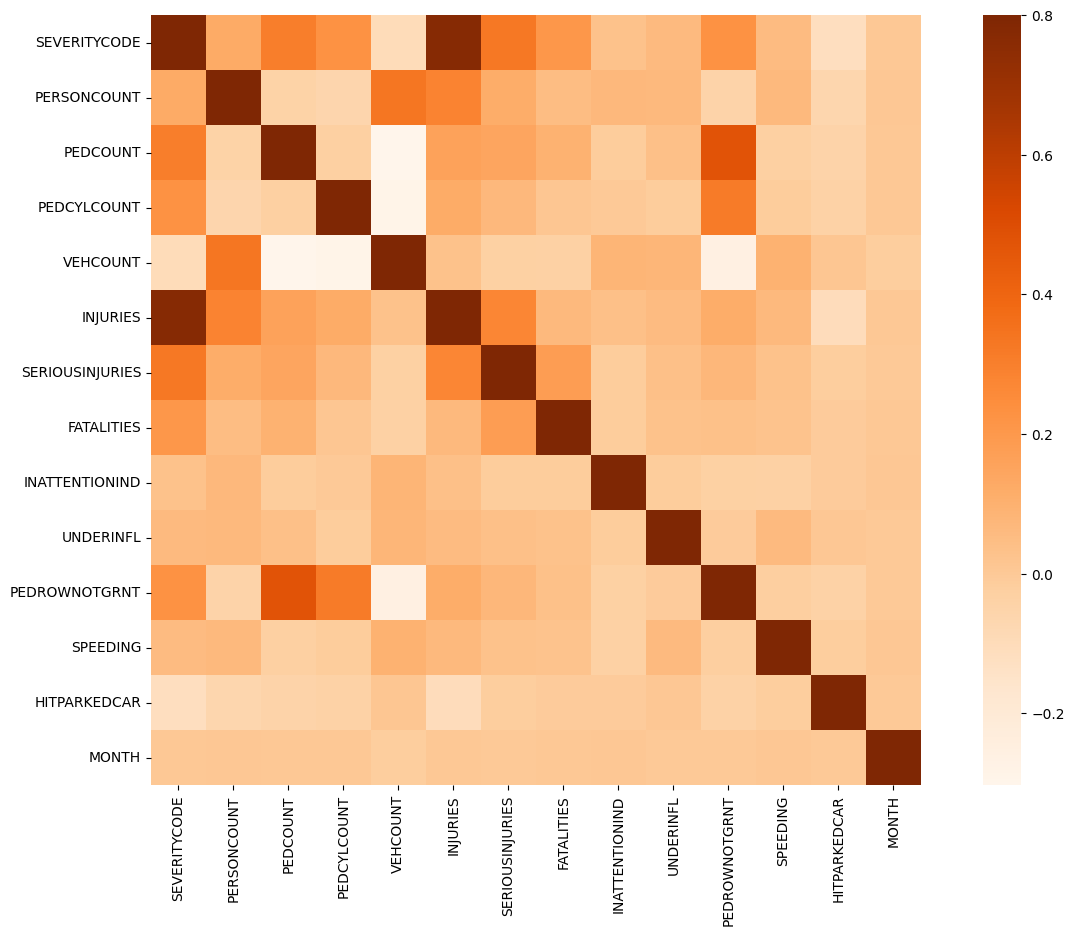

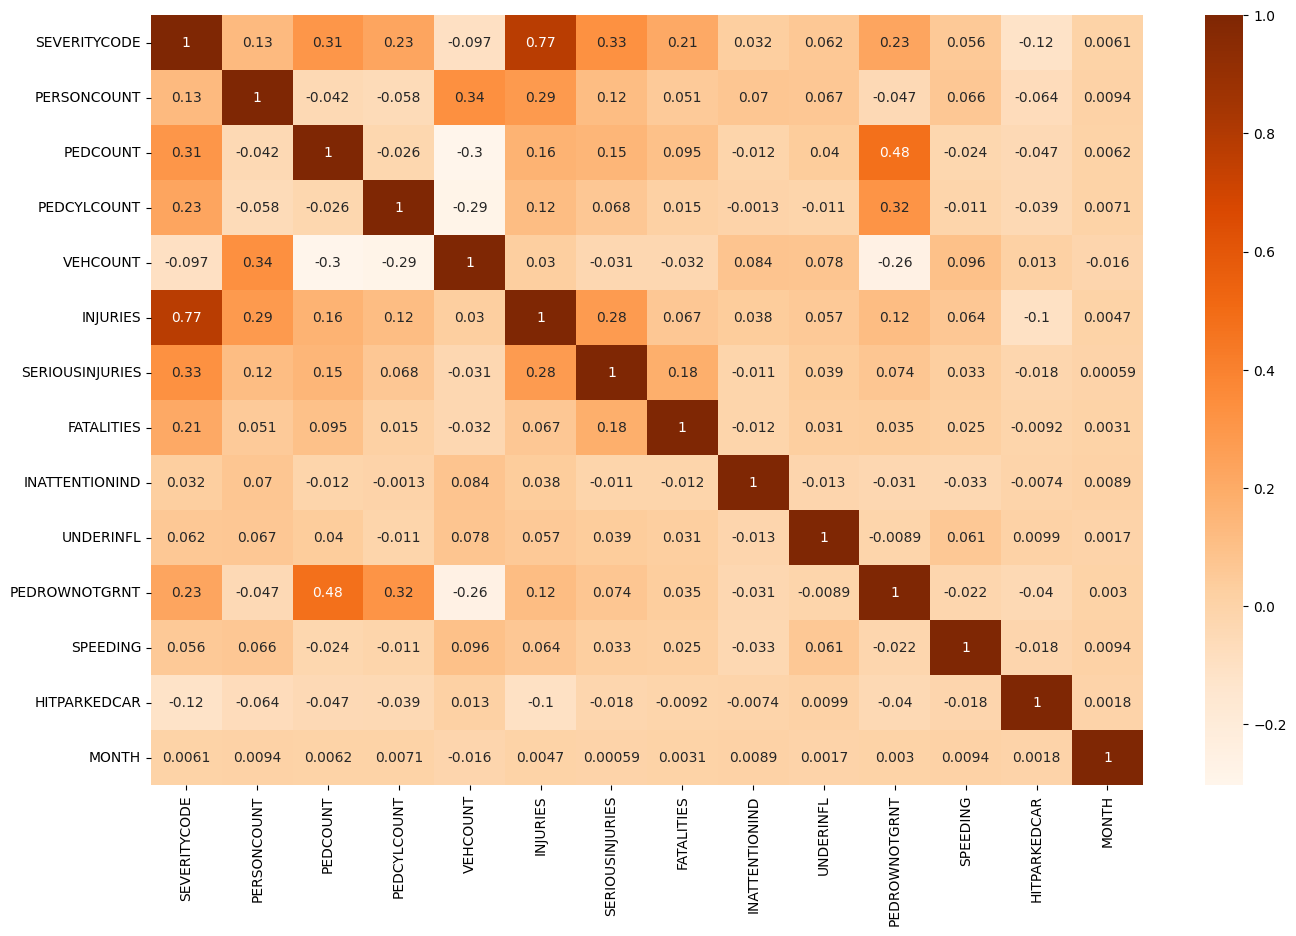

In [61]:
# The correlation coefficients between each feature
corr = data.corr()
f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(corr,cmap="Oranges", vmax=.8, square=True)

plt.figure(figsize=(16, 10))
sns.heatmap(corr, cmap="Oranges", annot=True)
#plt.savefig('The correlation coefficients between each feature.jpg',dpi=1080)
plt.show()

In [62]:
data.drop('PERSONCOUNT', axis=1, inplace=True)
data.drop('PEDCOUNT', axis=1, inplace=True)
data.drop('PEDCYLCOUNT', axis=1, inplace=True)
data.drop('VEHCOUNT', axis=1, inplace=True)
data.drop('INJURIES', axis=1, inplace=True)
data.drop('SERIOUSINJURIES', axis=1, inplace=True)
data.drop('FATALITIES', axis=1, inplace=True)
data.drop('PEDROWNOTGRNT', axis=1, inplace=True)

data.shape

(187157, 12)

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187157 entries, 0 to 240116
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   ADDRTYPE        187157 non-null  object
 1   SEVERITYCODE    187157 non-null  int64 
 2   COLLISIONTYPE   187157 non-null  object
 3   JUNCTIONTYPE    187157 non-null  object
 4   INATTENTIONIND  187157 non-null  int64 
 5   UNDERINFL       187157 non-null  int64 
 6   WEATHER         187157 non-null  object
 7   ROADCOND        187157 non-null  object
 8   LIGHTCOND       187157 non-null  object
 9   SPEEDING        187157 non-null  int64 
 10  HITPARKEDCAR    187157 non-null  int64 
 11  MONTH           187157 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 18.6+ MB


In [64]:
data.nunique()

ADDRTYPE           3
SEVERITYCODE       4
COLLISIONTYPE      9
JUNCTIONTYPE       6
INATTENTIONIND     2
UNDERINFL          2
WEATHER           10
ROADCOND           7
LIGHTCOND          6
SPEEDING           2
HITPARKEDCAR       2
MONTH             12
dtype: int64

# Section D: Algorithms implementation <a class="anchor" id="4"></a>

In [65]:
from sklearn.model_selection import train_test_split
X = data.drop('SEVERITYCODE',axis = 1)
y = data.SEVERITYCODE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [66]:
y.value_counts(dropna=False).to_frame()

,SEVERITYCODE
0,127258
1,56572
2,3006
3,321


In [67]:
y_train.value_counts(dropna=False).to_frame()

,SEVERITYCODE
0,88946
1,39712
2,2119
3,232


In [68]:
enc = OneHotEncoder(handle_unknown='value')

#Learn and apply the encoding on training set
X_train_enc = enc.fit_transform(X_train)
X_train_enc.head()

,ADDRTYPE_1,ADDRTYPE_2,ADDRTYPE_3,COLLISIONTYPE_1,COLLISIONTYPE_2,COLLISIONTYPE_3,COLLISIONTYPE_4,COLLISIONTYPE_5,COLLISIONTYPE_6,COLLISIONTYPE_7,...,ROADCOND_7,LIGHTCOND_1,LIGHTCOND_2,LIGHTCOND_3,LIGHTCOND_4,LIGHTCOND_5,LIGHTCOND_6,SPEEDING,HITPARKEDCAR,MONTH
56196,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,11
194253,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,10
66975,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,10
2228,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,11
75661,0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,7


In [69]:
X_train_enc.columns

Index(['ADDRTYPE_1', 'ADDRTYPE_2', 'ADDRTYPE_3', 'COLLISIONTYPE_1',
       'COLLISIONTYPE_2', 'COLLISIONTYPE_3', 'COLLISIONTYPE_4',
       'COLLISIONTYPE_5', 'COLLISIONTYPE_6', 'COLLISIONTYPE_7',
       'COLLISIONTYPE_8', 'COLLISIONTYPE_9', 'JUNCTIONTYPE_1',
       'JUNCTIONTYPE_2', 'JUNCTIONTYPE_3', 'JUNCTIONTYPE_4', 'JUNCTIONTYPE_5',
       'JUNCTIONTYPE_6', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER_1',
       'WEATHER_2', 'WEATHER_3', 'WEATHER_4', 'WEATHER_5', 'WEATHER_6',
       'WEATHER_7', 'WEATHER_8', 'WEATHER_9', 'WEATHER_10', 'ROADCOND_1',
       'ROADCOND_2', 'ROADCOND_3', 'ROADCOND_4', 'ROADCOND_5', 'ROADCOND_6',
       'ROADCOND_7', 'LIGHTCOND_1', 'LIGHTCOND_2', 'LIGHTCOND_3',
       'LIGHTCOND_4', 'LIGHTCOND_5', 'LIGHTCOND_6', 'SPEEDING', 'HITPARKEDCAR',
       'MONTH'],
      dtype='object')

In [70]:
X_test_enc = enc.transform(X_test)

In [72]:
from imblearn.over_sampling import SMOTE

#Initiate a SMOTE object
sm = SMOTE(random_state=42)

#Create the new (balanced) training set using SMOTE
X_train_enc_res, y_train_res = sm.fit_resample(X_train_enc, y_train)

In [73]:
X_train_small, _, y_train_small, _ = train_test_split(X_train_enc_res, y_train_res, test_size=0.999, random_state=42)

In [75]:
y_train_res.value_counts(dropna=False).to_frame()

,SEVERITYCODE
0,88946
1,88946
3,88946
2,88946


In [77]:
#pip install xgboost

In [78]:
folds = KFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
#pip install scikit-optimize

## MultinomialNB <a class="anchor" id="4.1"></a>

MultinomialNB (Multinomial Naive Bayes) is a classification algorithm that is based on Bayes' theorem, which works by calculating the probabilities of each feature given the class, and then combining these probabilities using Bayes' theorem to obtain the probability of each class given the features. The class with the highest probability is then chosen as the predicted class for the input data.


In [80]:
clf = MultinomialNB()

# 设置参数空间
parameters = {
    'alpha': (1e-5, 10.0, 'log-uniform'),
}

# 使用贝叶斯优化进行参数搜索
opt = BayesSearchCV(
    clf,
    parameters,
    cv=5,
    n_iter=20,
    random_state=42
)

opt.fit(X_train_enc_res, y_train_res)

best_params = opt.best_params_

print(best_params)
print(opt.best_score_)

OrderedDict([('alpha', 0.0028881766539144717)])
0.5142052464379121


MultinomialNB_train, CA        : 51.51%
MultinomialNB_train, Precision : 50.73%
MultinomialNB_train, Recall    : 51.51%
MultinomialNB_train, F1        : 50.69%
MultinomialNB_test,  CA        : 54.65%
MultinomialNB_test,  Precision : 68.17%
MultinomialNB_test,  Recall    : 54.65%
MultinomialNB_test,  F1        : 60.26%

              precision    recall  f1-score   support

           0       0.83      0.63      0.72     38312
           1       0.39      0.36      0.38     16860
           2       0.03      0.35      0.06       887
           3       0.02      0.44      0.04        89

    accuracy                           0.55     56148
   macro avg       0.32      0.45      0.30     56148
weighted avg       0.68      0.55      0.60     56148



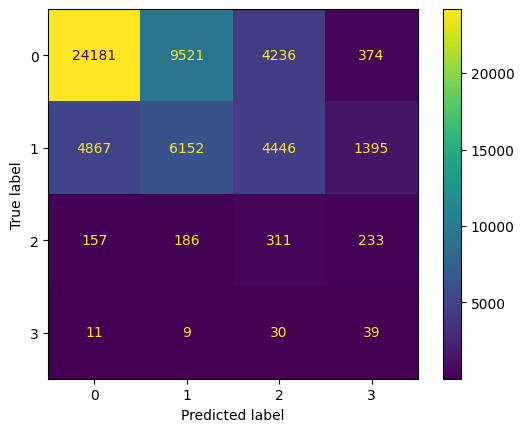

In [81]:
best_nb = MultinomialNB(
                        alpha = best_params['alpha'], 
                       
)

best_nb.fit(X_train_enc_res, y_train_res)
#best_nb.fit(X_train_small, y_train_small)

Y_train_pre = best_nb.predict(X_train_enc_res)
#Y_train_pre = best_nb.predict(X_train_small)
Y_test_pre = best_nb.predict(X_test_enc)


scores = {}

scores['MultinomialNB_train, CA'] = accuracy_score(y_train_res,Y_train_pre)
scores['MultinomialNB_train, Precision'] = precision_score(y_train_res,Y_train_pre, average='weighted')
scores['MultinomialNB_train, Recall'] = recall_score(y_train_res,Y_train_pre, average='weighted')
scores['MultinomialNB_train, F1'] = f1_score(y_train_res,Y_train_pre, average='weighted')

scores['MultinomialNB_test,  CA'] = accuracy_score(y_test,Y_test_pre)
scores['MultinomialNB_test,  Precision'] = precision_score(y_test, Y_test_pre, average='weighted')
scores['MultinomialNB_test,  Recall'] = recall_score(y_test, Y_test_pre, average='weighted')
scores['MultinomialNB_test,  F1'] = f1_score(y_test, Y_test_pre, average='weighted')

for k in scores:
    print('{0:31}: {1:5.2f}%'.format(k, np.mean(scores[k])*100) )
    
print()

CM=confusion_matrix(y_test,Y_test_pre)
ConfusionMatrixDisplay(CM).plot()
#plt.savefig('confusion_matrix_MultinomialNB.jpg',dpi=1080)
print(classification_report(y_test,Y_test_pre))

## Random Forest <a class="anchor" id="4.2"></a>

The random forest uses the integrated algorithm based on the decision tree to obtain multiple training sets through the returned random sampling. Each training set uses a classifier for training, and the final training results are obtained through the voting of the classifier. The random forest model is effective in classification, and the overfitting of the model can be reduced by increasing the number of trees. The parameters are set as follows:

In [82]:
# 定义参数网格
rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion':['entropy', 'gini']
}

# 定义随机森林分类器
rf = RandomForestClassifier(random_state=42)
# 使用网格搜索交叉验证
gs = GridSearchCV(rf,rf_param_grid,scoring='accuracy', n_jobs = -1, cv=5)
gs.fit(X_train_enc_res, y_train_res)

best_params = gs.best_params_

print(best_params)
print(gs.best_score_)

{'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
0.6803706879118522


RandomForest_train, CA         : 68.75%
RandomForest_train, Precision  : 69.17%
RandomForest_train, Recall     : 68.75%
RandomForest_train, F1         : 68.49%
RandomForest_test,  CA         : 59.42%
RandomForest_test,  Precision  : 72.82%
RandomForest_test,  Recall     : 59.42%
RandomForest_test,  F1         : 63.79%

              precision    recall  f1-score   support

           0       0.88      0.60      0.71     38312
           1       0.43      0.60      0.50     16860
           2       0.05      0.31      0.09       887
           3       0.02      0.25      0.03        89

    accuracy                           0.59     56148
   macro avg       0.34      0.44      0.33     56148
weighted avg       0.73      0.59      0.64     56148



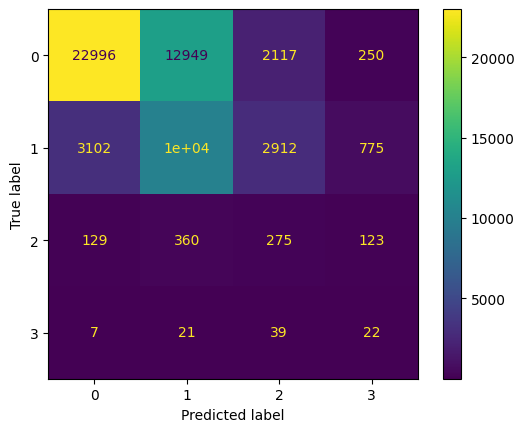

In [83]:
best_rf = RandomForestClassifier(
                        n_estimators = best_params['n_estimators'], 
                        max_depth = best_params['max_depth'], 
                        min_samples_split = best_params['min_samples_split'], 
                        min_samples_leaf = best_params['min_samples_leaf'], 
                        criterion = best_params['criterion'],
                        random_state=42)
best_rf.fit(X_train_enc_res, y_train_res)

Y_train_pre = best_rf.predict(X_train_enc_res)
#Y_train_pre = best_rf.predict(X_train_small)
Y_test_pre = best_rf.predict(X_test_enc)


scores = {}
scores['RandomForest_train, CA'] = accuracy_score(y_train_res,Y_train_pre)
scores['RandomForest_train, Precision'] = precision_score(y_train_res,Y_train_pre, average='weighted')
scores['RandomForest_train, Recall'] = recall_score(y_train_res,Y_train_pre, average='weighted')
scores['RandomForest_train, F1'] = f1_score(y_train_res,Y_train_pre, average='weighted')


scores['RandomForest_test,  CA'] = accuracy_score(y_test,Y_test_pre)
scores['RandomForest_test,  Precision'] = precision_score(y_test, Y_test_pre, average='weighted')
scores['RandomForest_test,  Recall'] = recall_score(y_test, Y_test_pre, average='weighted')
scores['RandomForest_test,  F1'] = f1_score(y_test, Y_test_pre, average='weighted')

for k in scores:
    print('{0:31}: {1:5.2f}%'.format(k, np.mean(scores[k])*100) )
    
print()
CM=confusion_matrix(y_test,Y_test_pre)
ConfusionMatrixDisplay(CM).plot()
#plt.savefig('confusion_matrix_RandomForest.jpg',dpi=1080)
print(classification_report(y_test,Y_test_pre))

## LinearSVC <a class="anchor" id="4.3"></a>

LinearSVC (Linear Support Vector Classification) is a machine learning algorithm for classification problems. It is like SVC with a linear kernel but is implemented using liblinear rather than libsvm, providing more flexibility in the choice of penalties and loss functions and better scalability for large numbers of samples.

In [86]:
svc = LinearSVC(max_iter=100, random_state=42)

# 定义需要进行网格搜索的超参数范围
svc_param_grid = {
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'C': [0.01, 0.1, 1, 10],
    'dual': [True, False]
}


# 进行网格搜索找出最优参数组合
gs = GridSearchCV(svc, svc_param_grid, scoring='accuracy', cv=5)

gs.fit(X_train_enc_res, y_train_res)

best_params = gs.best_params_

print(best_params)
print(gs.best_score_)

{'C': 10, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2'}
0.5952206964723266


LinearSVC_train, CA            : 59.57%
LinearSVC_train, Precision     : 60.92%
LinearSVC_train, Recall        : 59.57%
LinearSVC_train, F1            : 58.10%
LinearSVC_test,  CA            : 58.22%
LinearSVC_test,  Precision     : 73.64%
LinearSVC_test,  Recall        : 58.22%
LinearSVC_test,  F1            : 61.93%

              precision    recall  f1-score   support

           0       0.90      0.55      0.68     38312
           1       0.40      0.67      0.50     16860
           2       0.08      0.30      0.12       887
           3       0.02      0.30      0.04        89

    accuracy                           0.58     56148
   macro avg       0.35      0.45      0.34     56148
weighted avg       0.74      0.58      0.62     56148



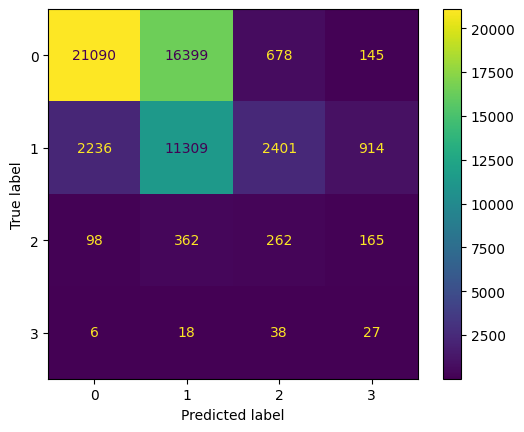

In [87]:
best_svc = LinearSVC(
            max_iter=100,        
            penalty = best_params['penalty'],
            loss = best_params['loss'], 
            C = best_params['C'], 
            dual = best_params['dual'],
            random_state=42
)

best_svc.fit(X_train_enc_res, y_train_res)

Y_train_pre = best_svc.predict(X_train_enc_res)
Y_test_pre = best_svc.predict(X_test_enc)

scores = {}
scores['LinearSVC_train, CA'] = accuracy_score(y_train_res,Y_train_pre)
scores['LinearSVC_train, Precision'] = precision_score(y_train_res,Y_train_pre, average='weighted')
scores['LinearSVC_train, Recall'] = recall_score(y_train_res,Y_train_pre, average='weighted')
scores['LinearSVC_train, F1'] = f1_score(y_train_res,Y_train_pre, average='weighted')

scores['LinearSVC_test,  CA'] = accuracy_score(y_test,Y_test_pre)
scores['LinearSVC_test,  Precision'] = precision_score(y_test, Y_test_pre, average='weighted')
scores['LinearSVC_test,  Recall'] = recall_score(y_test, Y_test_pre, average='weighted')
scores['LinearSVC_test,  F1'] = f1_score(y_test, Y_test_pre, average='weighted')

for k in scores:
    print('{0:31}: {1:5.2f}%'.format(k, np.mean(scores[k])*100) )
    
print()

CM=confusion_matrix(y_test,Y_test_pre)
ConfusionMatrixDisplay(CM).plot()
#plt.savefig('confusion_matrix_LinearSVC.jpg',dpi=1080)
print(classification_report(y_test,Y_test_pre))

## XGBoost <a class="anchor" id="4.4"></a>

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework and provides a parallel tree boosting algorithm that can solve many data science problems in a fast and accurate way.

In [88]:
model = xgb.XGBClassifier(random_state=42)

# 定义超参数空间
param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.1, 0.01, 0.001]

}



# 定义网格搜索对象
gs = GridSearchCV(estimator=model, param_grid=param_grid,scoring='accuracy',n_jobs = -1, cv=folds)
gs.fit(X_train_enc_res, y_train_res)

best_params = gs.best_params_

print(best_params)
print(gs.best_score_)

{'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 3}
0.6739960037371916


XGBClassifier_train, CA        : 67.73%
XGBClassifier_train, Precision : 68.14%
XGBClassifier_train, Recall    : 67.73%
XGBClassifier_train, F1        : 67.33%
XGBClassifier_test,  CA        : 59.59%
XGBClassifier_test,  Precision : 73.15%
XGBClassifier_test,  Recall    : 59.59%
XGBClassifier_test,  F1        : 63.79%

              precision    recall  f1-score   support

           0       0.88      0.59      0.71     38312
           1       0.43      0.62      0.51     16860
           2       0.06      0.31      0.10       887
           3       0.02      0.25      0.03        89

    accuracy                           0.60     56148
   macro avg       0.35      0.44      0.34     56148
weighted avg       0.73      0.60      0.64     56148



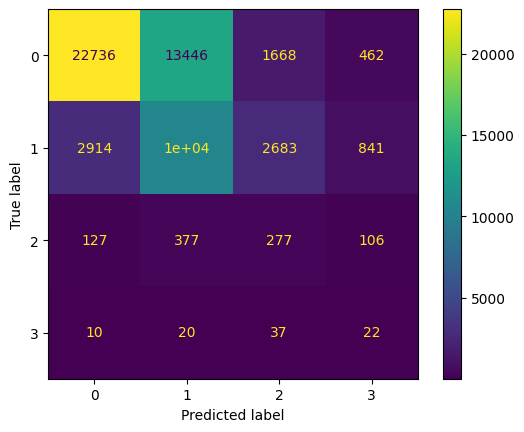

In [89]:

best_xg = xgb.XGBClassifier(
    max_depth=best_params['max_depth'], 
    learning_rate=best_params['learning_rate'], 
    min_child_weight=best_params['min_child_weight'], 
    random_state=42
)

best_xg.fit(X_train_enc_res, y_train_res)
#best_xg.fit(X_train_small, y_train_small)

Y_train_pre = best_xg.predict(X_train_enc_res)
#Y_train_pre = best_xg.predict(X_train_small)
Y_test_pre = best_xg.predict(X_test_enc)

scores = {}
scores['XGBClassifier_train, CA'] = accuracy_score(y_train_res,Y_train_pre)
scores['XGBClassifier_train, Precision'] = precision_score(y_train_res,Y_train_pre, average='weighted')
scores['XGBClassifier_train, Recall'] = recall_score(y_train_res,Y_train_pre, average='weighted')
scores['XGBClassifier_train, F1'] = f1_score(y_train_res,Y_train_pre, average='weighted')

scores['XGBClassifier_test,  CA'] = accuracy_score(y_test,Y_test_pre)
scores['XGBClassifier_test,  Precision'] = precision_score(y_test, Y_test_pre, average='weighted')
scores['XGBClassifier_test,  Recall'] = recall_score(y_test, Y_test_pre, average='weighted')
scores['XGBClassifier_test,  F1'] = f1_score(y_test, Y_test_pre, average='weighted')

for k in scores:
    print('{0:31}: {1:5.2f}%'.format(k, np.mean(scores[k])*100) )
    
print()

CM=confusion_matrix(y_test,Y_test_pre)
ConfusionMatrixDisplay(CM).plot()
#plt.savefig('confusion_matrix_XGBoost.jpg',dpi=1080)
print(classification_report(y_test,Y_test_pre))

Based on the comparison of the training and testing evaluation scores of all models using weight, it can be found that the difference in scores is very small, indicating that the models have good robustness.

## Section E: Results presented and analysis <a class="anchor" id="5"></a>

## Business understanding <a class="anchor" id="5.1"></a>

The code is used to output the feature importance ranking of each feature in the XGBoost model. Here, best_xg is the XGBoost classifier that has already been trained, and X_train_enc_res is the feature matrix that has been encoded using one-hot encoding.

The code first obtains the importance values of each feature through best_xg.feature_importances_, and then sorts the feature importance using np.argsort function to return the index values, which arranges the features from high to low based on their importance.

Finally, the code loops through each feature's ranking and importance value, and outputs the ranking, feature name, and its corresponding importance value.

In [90]:
importances = best_xg.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(X_train_enc_res.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train_enc_res.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. COLLISIONTYPE_4 (0.153407)
2. COLLISIONTYPE_8 (0.126959)
3. COLLISIONTYPE_3 (0.108674)
4. COLLISIONTYPE_6 (0.078609)
5. COLLISIONTYPE_7 (0.071190)
6. COLLISIONTYPE_5 (0.067587)
7. COLLISIONTYPE_2 (0.059069)
8. COLLISIONTYPE_1 (0.056442)
9. COLLISIONTYPE_9 (0.020715)
10. LIGHTCOND_3 (0.014342)
11. LIGHTCOND_4 (0.014240)
12. WEATHER_5 (0.011671)
13. ADDRTYPE_2 (0.011532)
14. JUNCTIONTYPE_2 (0.011395)
15. LIGHTCOND_6 (0.010474)
16. WEATHER_3 (0.010462)
17. INATTENTIONIND (0.010389)
18. SPEEDING (0.010246)
19. LIGHTCOND_2 (0.010120)
20. ROADCOND_1 (0.010114)
21. ROADCOND_4 (0.009714)
22. LIGHTCOND_5 (0.009595)
23. WEATHER_4 (0.009027)
24. WEATHER_7 (0.007734)
25. ROADCOND_2 (0.007725)
26. JUNCTIONTYPE_5 (0.007688)
27. WEATHER_1 (0.007670)
28. JUNCTIONTYPE_1 (0.007199)
29. LIGHTCOND_1 (0.006903)
30. WEATHER_2 (0.006254)
31. MONTH (0.005870)
32. ROADCOND_3 (0.005586)
33. ADDRTYPE_1 (0.005095)
34. UNDERINFL (0.005084)
35. JUNCTIONTYPE_3 (0.004978)
36. HITPARKEDCAR (0.00469

This code computes feature importance using XGBoost and then aggregates the importance scores by grouping them based on the original feature names (which are obtained by removing the suffixes generated by one-hot encoding). Here's a breakdown of what each line does:

importance = best_xg.get_booster().get_score(importance_type='gain'): Calculates the importance of each feature using the 'gain' method. This method measures the relative contribution of each feature to the model based on the average gain in accuracy obtained by using that feature for splitting data across all trees in the ensemble.

importance_df = pd.DataFrame.from_dict(importance, orient='index', columns=['score']): Converts the importance dictionary to a Pandas DataFrame where each row represents a feature and its importance score.

importance_df.reset_index(inplace=True): Resets the index of the DataFrame so that the original feature names become a column called 'index'.

importance_df.rename(columns={'index': 'feature'}, inplace=True): Renames the 'index' column to 'feature' to make the DataFrame easier to work with.

importance_df = importance_df.nlargest(46, 'score').sort_values('score', ascending=False): Sorts the DataFrame in descending order based on importance scores and selects the all features.

importance_df['original_feature'] = importance_df['feature'].apply(lambda x: x.split('_')[0]): Extracts the original feature names from the one-hot encoded column names by removing the suffixes generated by the encoding.

importance_df = importance_df.groupby('original_feature')['score'].sum().reset_index(): Groups the importance scores by their original feature names and sums them up to obtain the total importance score for each original feature.

importance_df.sort_values(by='score', ascending=False, inplace=True): Sorts the DataFrame in descending order based on the total importance scores.

print(importance_df): Prints the final DataFrame containing the total importance scores for each original feature.






In [142]:
importance = best_xg.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame.from_dict(importance, orient='index', columns=['score'])
importance_df.reset_index(inplace=True)
importance_df.rename(columns={'index': 'feature'}, inplace=True)
importance_df = importance_df.nlargest(46, 'score').sort_values('score', ascending=False)
importance_df['original_feature'] = importance_df['feature'].apply(lambda x: x.split('_')[0])
importance_df = importance_df.groupby('original_feature')['score'].sum().reset_index()
importance_df.sort_values(by='score', ascending=False, inplace=True)
print(importance_df)

   original_feature        score
1     COLLISIONTYPE  2851.575699
5         LIGHTCOND   252.171396
10          WEATHER   215.639247
7          ROADCOND   159.487008
4      JUNCTIONTYPE   142.513245
0          ADDRTYPE    79.033663
3    INATTENTIONIND    39.892647
8          SPEEDING    39.341118
6             MONTH    22.540382
9         UNDERINFL    19.520864
2      HITPARKEDCAR    18.011589


In order to make better recommendations, this analysis will explore what values are represented by the one-hot encoded features.





In [123]:
X_train_enc.COLLISIONTYPE_4.value_counts(dropna=False).to_frame()

,COLLISIONTYPE_4
0,94515
1,36494


In [124]:
X_train_enc.COLLISIONTYPE_8.value_counts(dropna=False).to_frame()

,COLLISIONTYPE_8
0,124965
1,6044


In [125]:
X_train_enc.COLLISIONTYPE_3.value_counts(dropna=False).to_frame()

,COLLISIONTYPE_3
0,116497
1,14512


In [126]:
X_train.COLLISIONTYPE.value_counts(dropna=False).to_frame()

,COLLISIONTYPE
Parked Car,36494
Angles,27749
Rear Ended,26533
Sideswipe,14512
Left Turn,10911
Pedestrian,6044
Cycles,4703
Right Turn,2308
Head On,1755


COLLISIONTYPE_4:Parked Car

COLLISIONTYPE_8:Pedestrian

COLLISIONTYPE_3:Sideswipe

In [127]:
X_train_enc.LIGHTCOND_3.value_counts(dropna=False).to_frame()

,LIGHTCOND_3
0,129204
1,1805


In [128]:
X_train_enc.LIGHTCOND_4.value_counts(dropna=False).to_frame()

,LIGHTCOND_4
0,129107
1,1902


In [132]:
X_train_enc.LIGHTCOND_6.value_counts(dropna=False).to_frame()

,LIGHTCOND_6
0,130909
1,100


In [129]:
X_train.LIGHTCOND.value_counts(dropna=False).to_frame()

,LIGHTCOND
Daylight,88186
Dark - Street Lights On,34528
Dusk,4488
Dark - No Lighting,1902
Dawn,1805
Dark - Unknown Lighting,100


LIGHTCOND_3:Dawn

LIGHTCOND_4:Dark - No Lighting

LIGHTCOND_6:Dark - Unknown Lighting

In [130]:
X_train_enc.ADDRTYPE_2.value_counts(dropna=False).to_frame()

,ADDRTYPE_2
1,81607
0,49402


In [131]:
X_train.ADDRTYPE.value_counts(dropna=False).to_frame()

,ADDRTYPE
Block,81607
Intersection,49066
Alley,336


ADDRTYPE_2:Block

In [133]:
X_train_enc.JUNCTIONTYPE_2.value_counts(dropna=False).to_frame()

,JUNCTIONTYPE_2
0,116452
1,14557


In [134]:
X_train.JUNCTIONTYPE.value_counts(dropna=False).to_frame()

,JUNCTIONTYPE
Mid-Block (not related to intersection),61215
At Intersection (intersection related),48546
Mid-Block (but intersection related),14557
Driveway Junction,5160
At Intersection (but not related to intersection),1431
Ramp Junction,100


JUNCTIONTYPE_2:Mid-Block (but intersection related)

In [136]:
X_train_enc.WEATHER_3.value_counts(dropna=False).to_frame()

,WEATHER_3
1,85040
0,45969


In [138]:
X_train_enc.WEATHER_4.value_counts(dropna=False).to_frame()

,WEATHER_4
0,130581
1,428


In [137]:
X_train.WEATHER.value_counts(dropna=False).to_frame()

,WEATHER
Clear,85040
Raining,23851
Overcast,20915
Snowing,620
Fog/Smog/Smoke,428
Sleet/Hail/Freezing Rain,75
Blowing Sand/Dirt,42
Partly Cloudy,24
Severe Crosswind,13
Blowing Snow,1


WEATHER_3:Clear

WEATHER_4:Fog/Smog/Smoke

Factors that contribute to higher severity in traffic accidents include collision types involving Parked Cars and Pedestrian, Sideswipe, accidents at Intersections, and in ‘Block’ road types. Poor lighting conditions, particularly at Dawn and in the absence of streetlights, may also increase severity. Inattention and Speeding violations are other factors that may affect accident severity, so it is important to drive carefully and obey traffic rules.
